# **CASO DE ESTUDIO AGRUPAMIENTO: Reto Digitalización 3 - Fallas en Red Eléctrica**

A partir de los datos de sus clientes, se desea conocer si alguno de los datos tomados por un medidor representa un fallo en la red eléctrica para tomar acciones correctivas en el menor tiempo posible.

# Metodología ASUM-DM

1. Entendimiento del negocio: La empresa energética busca conocer el estado de su red eléctrica para tomar acciones correctivas en caso de ser necesario.

2. Entendimiento analítico: Diseñar un experimento que permita agrupar en una cantidad específica de grupos las mediciones de estaciones en la red eléctrica para determinar si se deben aplicar acciones correctivas. 

3. Requemiento de datos: Se requieren datos de las estaciones de medida que incluyan voltaje rms, corriente rms, consumo energético y frecuencia idealmente. El mínimo requisito es el consumo energético.

4. Recolección de datos: Se tiene un primer dataset de 401 clientes reales tomados en Colombia en zonas de estratos 3 y 4, donde se incluye el id del medidor, la fecha de la muestra y el consumo energético en KWh. 

5. Entendimiento de los datos:
- Identificar la existencia de datos nulos
- Exploración univaridad de los datos
- Exploración multivariada de los datos
- Identificación de correlación y multicolinealidad

In [1]:
#Librerías
##Tratamiento estructurado de datos

import pandas as pd
import numpy as np

##Gráficos
import matplotlib.pyplot as plt
import seaborn as sb

##Advertencias
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/medidores_EIA.csv', sep=';') #Lectura del archivo CSV
data

,ID,FECHA,KWH_IMPORT
0,MED_399,2024-01-04,"1310,28"
1,MED_399,2024-01-16,"1358,004"
2,MED_399,2024-01-29,"1412,016"
3,MED_4,2024-01-09,"745,201"
4,MED_4,2024-01-11,"745,201"
...,...,...,...
143873,MED_375,2024-12-08 00:00:00,"2743,368"
143874,MED_50,2024-12-01 00:00:00,"403,314"
143875,MED_366,2024-12-26 00:00:00,"193,289"
143876,MED_287,2024-12-19 00:00:00,"854,451"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143878 entries, 0 to 143877
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID          143878 non-null  object
 1   FECHA       143878 non-null  object
 2   KWH_IMPORT  143878 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


In [4]:
#Cambiar KWH_IMPORT a float y fecha a datetime
data['KWH_IMPORT'] = data['KWH_IMPORT'].str.replace(',', '.').astype(float)
data['FECHA'] = pd.to_datetime(data['FECHA'].str.slice(0,10), format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143878 entries, 0 to 143877
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ID          143878 non-null  object        
 1   FECHA       143878 non-null  datetime64[ns]
 2   KWH_IMPORT  143878 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.3+ MB


<Axes: xlabel='FECHA', ylabel='KWH_IMPORT'>

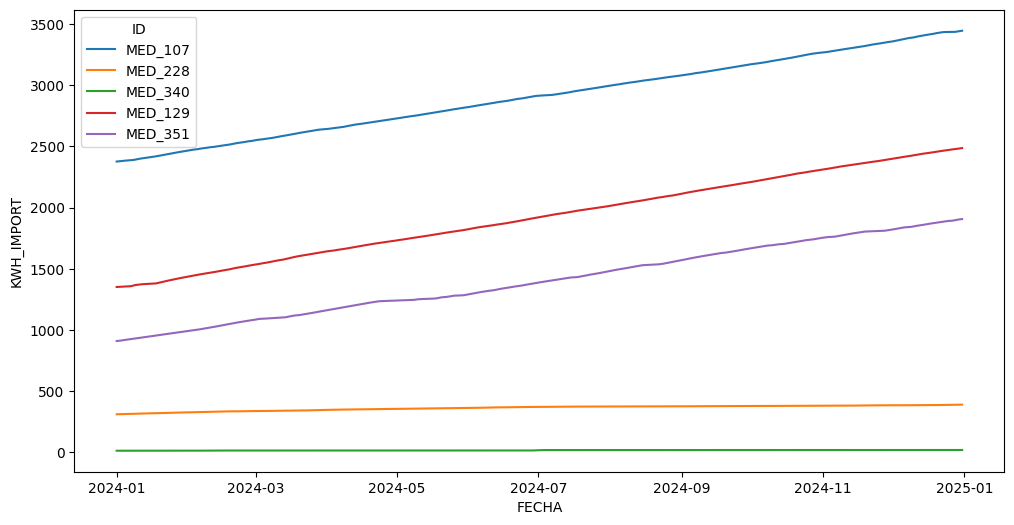

In [5]:
#Graficar comportamiento de KWH_IMPORT de 5 medidores aleatorios
plt.figure(figsize=(12, 6))
sample_ids = data['ID'].drop_duplicates().sample(5, random_state=42)
sample_data = data[data['ID'].isin(sample_ids)]
sb.lineplot(data=sample_data, x='FECHA', y='KWH_IMPORT', hue='ID')

In [6]:
# Check for meter saturation/reset (where KWH_IMPORT decreases or goes to zero)
# Group by meter and check if any reading is less than the previous one

meter_resets = []
for meter_id in data['ID'].unique():
    meter_data = data[data['ID'] == meter_id].sort_values('FECHA')
    # Check if any reading decreases (indicating a reset)
    decreases = (meter_data['KWH_IMPORT'].diff() < 0).sum()
    if decreases > 0:
        meter_resets.append({
            'ID': meter_id,
            'num_resets': decreases,
            'min_kwh': meter_data['KWH_IMPORT'].min(),
            'max_kwh': meter_data['KWH_IMPORT'].max()
        })

if meter_resets:
    print(f"Found {len(meter_resets)} meters with resets/saturation:")
    pd.DataFrame(meter_resets)
else:
    print("No meter resets detected. All KWH_IMPORT values are monotonically increasing per meter.")

No meter resets detected. All KWH_IMPORT values are monotonically increasing per meter.


In [7]:
# Ensure data is sorted by FECHA before calculating CONSUMO_NETO
data_mod = data.sort_values(['ID', 'FECHA']).reset_index(drop=True)

# Recalculate CONSUMO_NETO with sorted data
data_mod['CONSUMO_NETO'] = data_mod.groupby('ID')['KWH_IMPORT'].diff()

# Check for negative consumption values
negative_consumo = data_mod[data_mod['CONSUMO_NETO'] < 0]
print(f"Found {len(negative_consumo)} negative CONSUMO_NETO values")
print(f"From {negative_consumo['ID'].nunique()} different meters")
print(f"\nSample of negative values:")
negative_consumo[['ID', 'FECHA', 'KWH_IMPORT', 'CONSUMO_NETO']].head(10)

Found 0 negative CONSUMO_NETO values
From 0 different meters

Sample of negative values:


,ID,FECHA,KWH_IMPORT,CONSUMO_NETO


In [8]:
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143878 entries, 0 to 143877
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ID            143878 non-null  object        
 1   FECHA         143878 non-null  datetime64[ns]
 2   KWH_IMPORT    143878 non-null  float64       
 3   CONSUMO_NETO  143477 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.4+ MB


In [9]:
#Eliminate NaN CONSUMO_NETO values (first reading per meter)
data_mod = data_mod.dropna(subset=['CONSUMO_NETO']).reset_index(drop=True)
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143477 entries, 0 to 143476
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ID            143477 non-null  object        
 1   FECHA         143477 non-null  datetime64[ns]
 2   KWH_IMPORT    143477 non-null  float64       
 3   CONSUMO_NETO  143477 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 4.4+ MB


In [10]:
# Check for meters with ALL readings as zero consumption
meter_consumption_counts = data_mod.groupby('ID')['CONSUMO_NETO'].apply(lambda x: (x == 0).sum())
meter_total_counts = data_mod.groupby('ID').size()

# Find meters where ALL values are zero
meters_with_all_zero = meter_consumption_counts[meter_consumption_counts == meter_total_counts]

if not meters_with_all_zero.empty:
    print(f"Found {len(meters_with_all_zero)} meters with all CONSUMO_NETO as zero:")
    print(meters_with_all_zero.index.tolist())
    
    # Remove these faulty meters
    data_mod = data_mod[~data_mod['ID'].isin(meters_with_all_zero.index)]
    print(f"\nRemoved {len(meters_with_all_zero)} faulty meters")
    print(f"Remaining data: {len(data_mod)} rows from {data_mod['ID'].nunique()} meters")
else:
    print("No meters with all-zero consumption found.")

Found 8 meters with all CONSUMO_NETO as zero:
['MED_120', 'MED_123', 'MED_200', 'MED_300', 'MED_330', 'MED_376', 'MED_401', 'MED_46']

Removed 8 faulty meters
Remaining data: 140628 rows from 393 meters


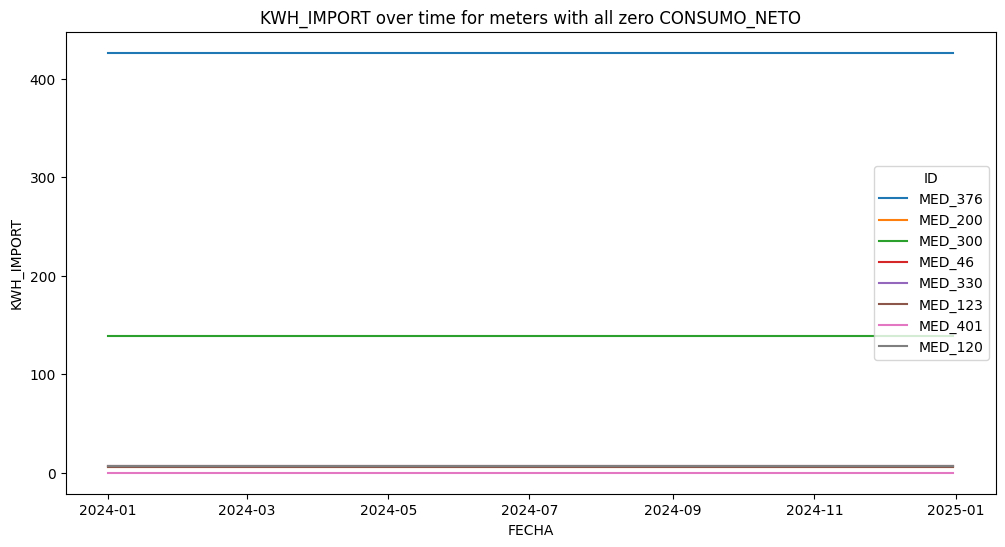

In [11]:
#Graph KWH_IMPORT over time for the meters that were removed. This must be done using the original data variable
plt.figure(figsize=(12, 6))
sample_data = data[data['ID'].isin(meters_with_all_zero.index)]
sb.lineplot(data=sample_data, x='FECHA', y='KWH_IMPORT', hue='ID')
plt.title('KWH_IMPORT over time for meters with all zero CONSUMO_NETO')
plt.show()

In [12]:
#Show data for a specific meter ID
ID = 'MED_340'
data_mod[data_mod['ID'] == ID]

,ID,FECHA,KWH_IMPORT,CONSUMO_NETO
95788,MED_340,2024-01-02,13.791,0.000
95789,MED_340,2024-01-03,13.791,0.000
95790,MED_340,2024-01-04,13.791,0.000
95791,MED_340,2024-01-05,13.791,0.000
95792,MED_340,2024-01-06,13.791,0.000
...,...,...,...,...
96142,MED_340,2024-12-27,19.610,0.000
96143,MED_340,2024-12-28,19.610,0.000
96144,MED_340,2024-12-29,19.610,0.000
96145,MED_340,2024-12-30,19.610,0.000


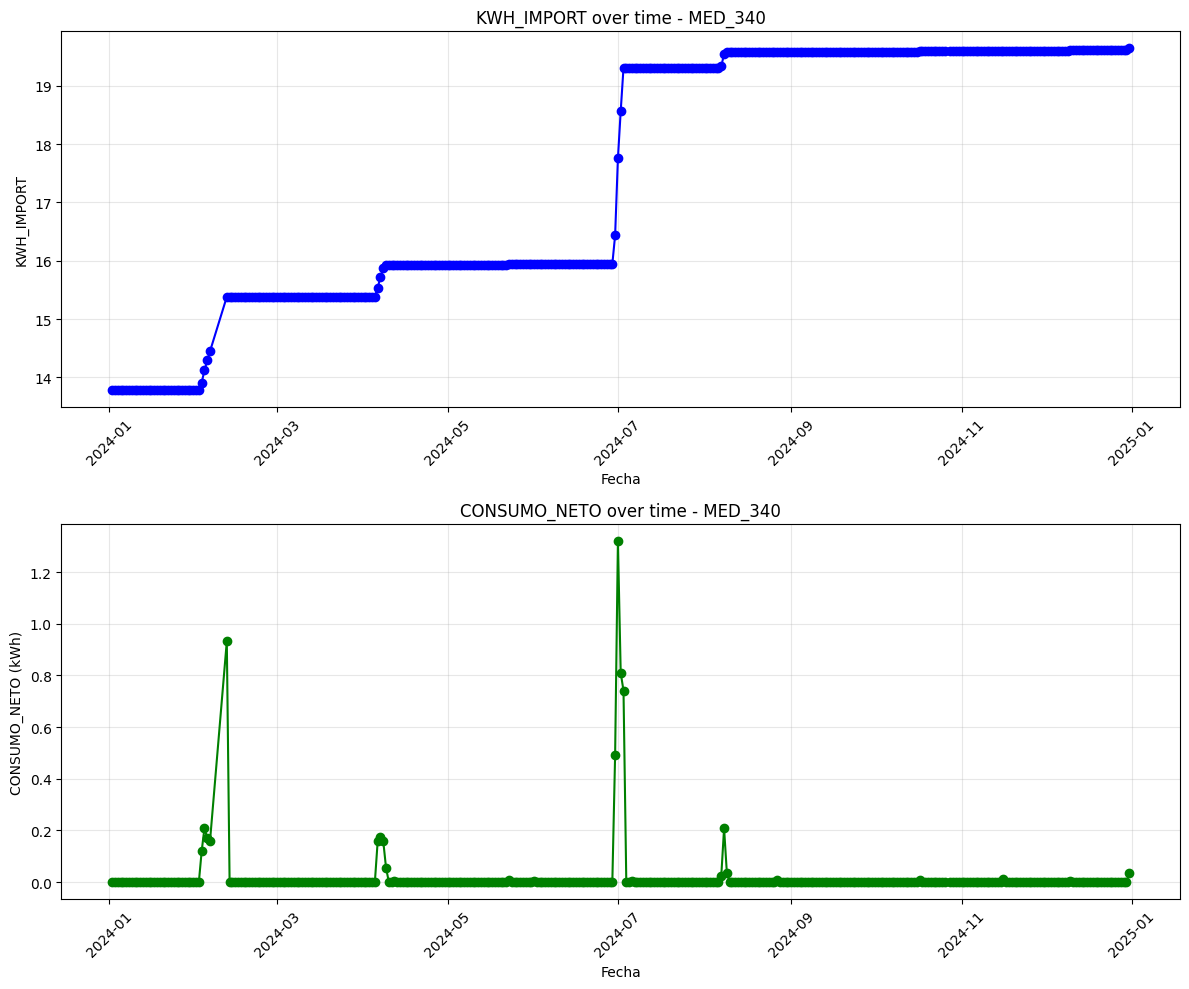

In [13]:
# Graph KWH_import and consumo neto in 2 different subplots from meter with a specified ID
ID = 'MED_340'
meter_data = data_mod[data_mod['ID'] == ID]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Subplot 1: KWH_IMPORT over time
ax1.plot(meter_data['FECHA'], meter_data['KWH_IMPORT'], marker='o', linestyle='-', color='blue')
ax1.set_title(f'KWH_IMPORT over time - {ID}')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('KWH_IMPORT')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Subplot 2: CONSUMO_NETO over time
ax2.plot(meter_data['FECHA'], meter_data['CONSUMO_NETO'], marker='o', linestyle='-', color='green')
ax2.set_title(f'CONSUMO_NETO over time - {ID}')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('CONSUMO_NETO (kWh)')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

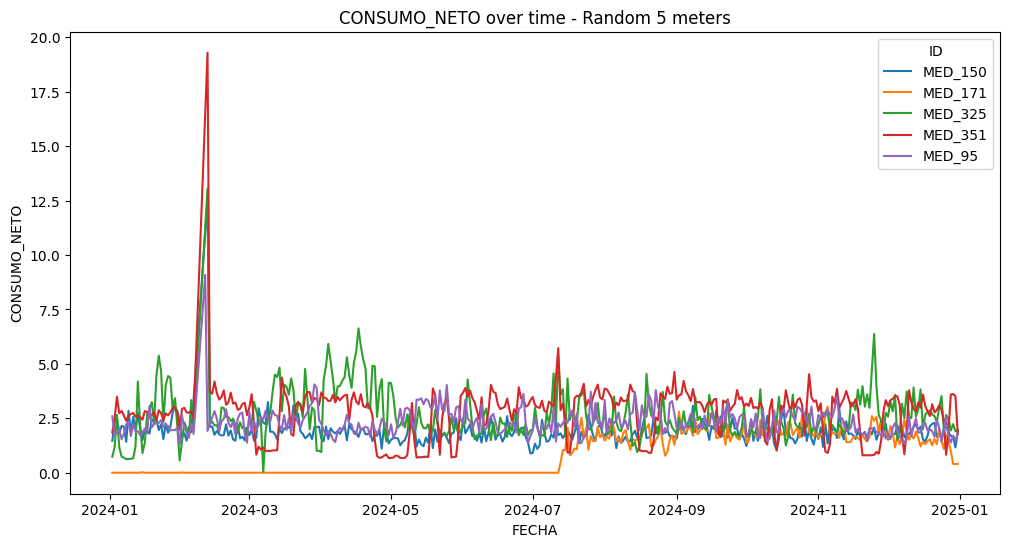

In [14]:
#Graficar comportamiento de consumo neto de 5 medidores aleatorios
plt.figure(figsize=(12, 6))
sample_ids = data_mod['ID'].drop_duplicates().sample(5, random_state=42)
sample_data = data_mod[data_mod['ID'].isin(sample_ids)]
sb.lineplot(data=sample_data, x='FECHA', y='CONSUMO_NETO', hue='ID')
plt.title('CONSUMO_NETO over time - Random 5 meters')
plt.show()

In [15]:
#Desagregar columna de fecha (año-mes-día) en tres columnas separadas tipo int64
data_mod['AÑO'] = data_mod['FECHA'].dt.year.astype('int64')
data_mod['MES'] = data_mod['FECHA'].dt.month.astype('int64')
data_mod['DÍA'] = data_mod['FECHA'].dt.day.astype('int64')
data_mod.head()

,ID,FECHA,KWH_IMPORT,CONSUMO_NETO,AÑO,MES,DÍA
0,MED_1,2024-01-02,2228.011,3.720,2024,1,2
1,MED_1,2024-01-03,2232.242,4.231,2024,1,3
2,MED_1,2024-01-04,2236.610,4.368,2024,1,4
3,MED_1,2024-01-05,2241.066,4.456,2024,1,5
4,MED_1,2024-01-06,2245.554,4.488,2024,1,6


In [16]:
data_mod.tail()

,ID,FECHA,KWH_IMPORT,CONSUMO_NETO,AÑO,MES,DÍA
143472,MED_99,2024-12-27,1842.094,2.579,2024,12,27
143473,MED_99,2024-12-28,1844.307,2.213,2024,12,28
143474,MED_99,2024-12-29,1846.708,2.401,2024,12,29
143475,MED_99,2024-12-30,1849.282,2.574,2024,12,30
143476,MED_99,2024-12-31,1851.957,2.675,2024,12,31


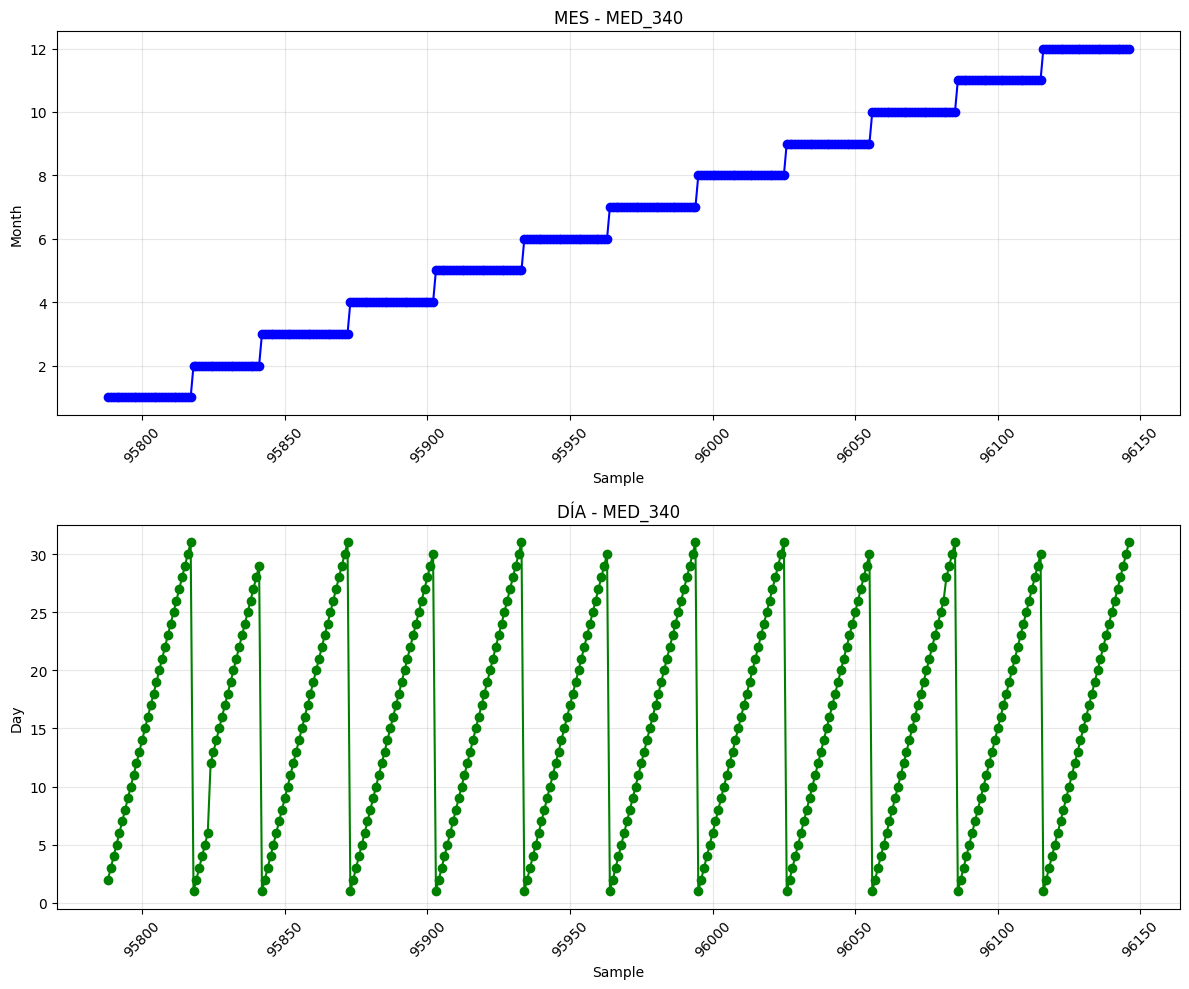

In [17]:
# Graph MES and DÍA neto in 2 different subplots from meter with a specified ID
ID = 'MED_340'
meter_data = data_mod[data_mod['ID'] == ID]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Subplot 1: Mes
ax1.plot(meter_data['MES'], marker='o', linestyle='-', color='blue')
ax1.set_title(f'MES - {ID}')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Month')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Subplot 2: DÍA
ax2.plot(meter_data['DÍA'], marker='o', linestyle='-', color='green')
ax2.set_title(f'DÍA - {ID}')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Day')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [18]:
# Encode MES and DÍA as cyclical features

# MONTH: Cycles every 12 months (1-12)
data_mod['MES_sin'] = np.sin(2 * np.pi * data_mod['MES'] / 12.0)
data_mod['MES_cos'] = np.cos(2 * np.pi * data_mod['MES'] / 12.0)

# DAY: Cycles approximately every 30 days (1-31)
# Using 31 as max since it's the maximum possible day value
data_mod['DIA_sin'] = np.sin(2 * np.pi * data_mod['DÍA'] / 31.0)
data_mod['DIA_cos'] = np.cos(2 * np.pi * data_mod['DÍA'] / 31.0)

# Display sample to verify
print("Original and encoded cyclical features:")
data_mod[['FECHA', 'MES', 'DÍA', 'MES_sin', 'MES_cos', 'DIA_sin', 'DIA_cos']].head(10)

Original and encoded cyclical features:


,FECHA,MES,DÍA,MES_sin,MES_cos,DIA_sin,DIA_cos
0,2024-01-02,1,2,0.5,0.866025,0.394356,0.918958
1,2024-01-03,1,3,0.5,0.866025,0.571268,0.820763
2,2024-01-04,1,4,0.5,0.866025,0.724793,0.688967
3,2024-01-05,1,5,0.5,0.866025,0.848644,0.528964
4,2024-01-06,1,6,0.5,0.866025,0.937752,0.347305
5,2024-01-07,1,7,0.5,0.866025,0.988468,0.151428
6,2024-01-08,1,8,0.5,0.866025,0.998717,-0.050649
7,2024-01-09,1,9,0.5,0.866025,0.968077,-0.250653
8,2024-01-10,1,10,0.5,0.866025,0.897805,-0.440394
9,2024-01-11,1,11,0.5,0.866025,0.790776,-0.612106


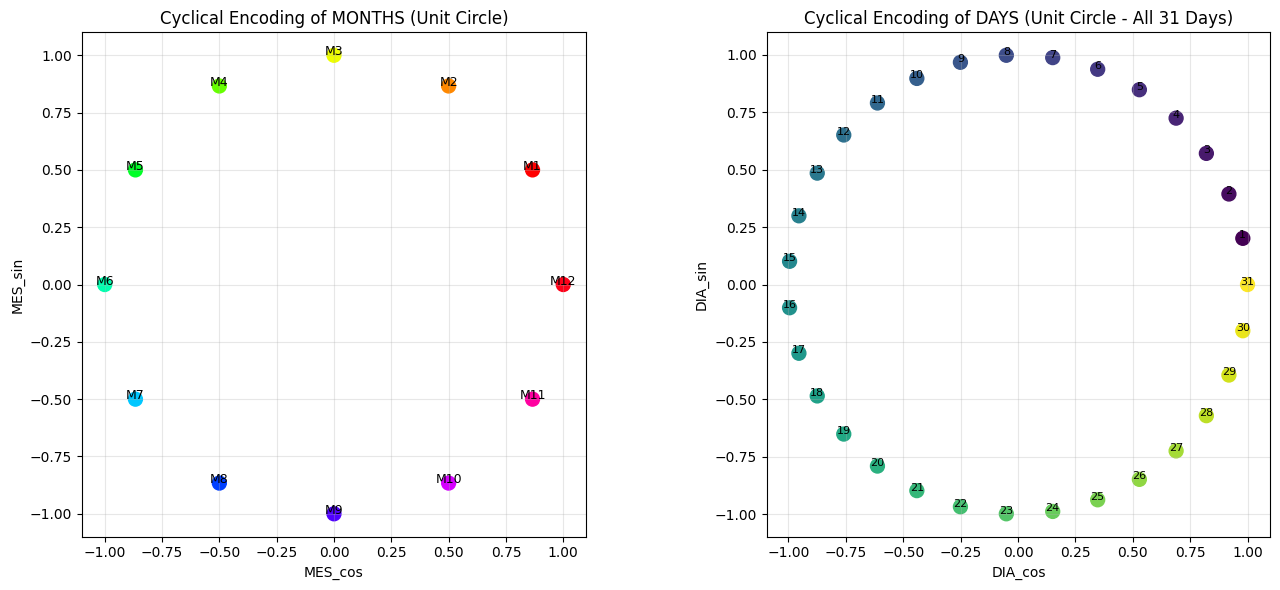

In [19]:
# Visualize cyclical encoding on unit circle
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot MONTH cyclical encoding
months_unique = data_mod[['MES', 'MES_sin', 'MES_cos']].drop_duplicates().sort_values('MES')
ax1.scatter(months_unique['MES_cos'], months_unique['MES_sin'], s=100, c=months_unique['MES'], cmap='hsv')
for _, row in months_unique.iterrows():
    ax1.annotate(f"M{int(row['MES'])}", (row['MES_cos'], row['MES_sin']), 
                 fontsize=9, ha='center')
ax1.set_xlabel('MES_cos')
ax1.set_ylabel('MES_sin')
ax1.set_title('Cyclical Encoding of MONTHS (Unit Circle)')
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# Plot DAY cyclical encoding - ALL 31 DAYS
days_all = data_mod[['DÍA', 'DIA_sin', 'DIA_cos']].drop_duplicates().sort_values('DÍA')
ax2.scatter(days_all['DIA_cos'], days_all['DIA_sin'], s=100, c=days_all['DÍA'], cmap='viridis')
for _, row in days_all.iterrows():
    ax2.annotate(f"{int(row['DÍA'])}", (row['DIA_cos'], row['DIA_sin']), 
                 fontsize=8, ha='center')
ax2.set_xlabel('DIA_cos')
ax2.set_ylabel('DIA_sin')
ax2.set_title('Cyclical Encoding of DAYS (Unit Circle - All 31 Days)')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

In [20]:
#Add context variable for better fault detection
data_mod_enhanced = data_mod.copy()

# Add meter statistics as additional features (context for each reading)
meter_stats = data_mod.groupby('ID')['CONSUMO_NETO'].agg(['mean', 'std']).reset_index()
meter_stats.columns = ['ID', 'METER_AVG_CONSUMO', 'METER_STD_CONSUMO']

# Merge back to original data
data_mod_enhanced = data_mod_enhanced.merge(meter_stats, on='ID', how='left')

# Create "deviation from meter's norm" feature
data_mod_enhanced['CONSUMO_DEVIATION'] = (
    (data_mod_enhanced['CONSUMO_NETO'] - data_mod_enhanced['METER_AVG_CONSUMO']) / 
    (data_mod_enhanced['METER_STD_CONSUMO'] + 1e-6)  # Avoid division by zero
)

print(f"Shape: {data_mod_enhanced.shape}")
print(f"Features: {data_mod_enhanced.columns.tolist()}")


Shape: (140628, 14)
Features: ['ID', 'FECHA', 'KWH_IMPORT', 'CONSUMO_NETO', 'AÑO', 'MES', 'DÍA', 'MES_sin', 'MES_cos', 'DIA_sin', 'DIA_cos', 'METER_AVG_CONSUMO', 'METER_STD_CONSUMO', 'CONSUMO_DEVIATION']


In [21]:
data_mod_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140628 entries, 0 to 140627
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 140628 non-null  object        
 1   FECHA              140628 non-null  datetime64[ns]
 2   KWH_IMPORT         140628 non-null  float64       
 3   CONSUMO_NETO       140628 non-null  float64       
 4   AÑO                140628 non-null  int64         
 5   MES                140628 non-null  int64         
 6   DÍA                140628 non-null  int64         
 7   MES_sin            140628 non-null  float64       
 8   MES_cos            140628 non-null  float64       
 9   DIA_sin            140628 non-null  float64       
 10  DIA_cos            140628 non-null  float64       
 11  METER_AVG_CONSUMO  140628 non-null  float64       
 12  METER_STD_CONSUMO  140628 non-null  float64       
 13  CONSUMO_DEVIATION  140628 non-null  float64 

In [22]:
data_mod_enhanced

,ID,FECHA,KWH_IMPORT,CONSUMO_NETO,AÑO,MES,DÍA,MES_sin,MES_cos,DIA_sin,DIA_cos,METER_AVG_CONSUMO,METER_STD_CONSUMO,CONSUMO_DEVIATION
0,MED_1,2024-01-02,2228.011,3.720,2024,1,2,5.000000e-01,0.866025,3.943559e-01,0.918958,4.483816,1.109833,-0.688226
1,MED_1,2024-01-03,2232.242,4.231,2024,1,3,5.000000e-01,0.866025,5.712682e-01,0.820763,4.483816,1.109833,-0.227796
2,MED_1,2024-01-04,2236.610,4.368,2024,1,4,5.000000e-01,0.866025,7.247928e-01,0.688967,4.483816,1.109833,-0.104355
3,MED_1,2024-01-05,2241.066,4.456,2024,1,5,5.000000e-01,0.866025,8.486443e-01,0.528964,4.483816,1.109833,-0.025063
4,MED_1,2024-01-06,2245.554,4.488,2024,1,6,5.000000e-01,0.866025,9.377521e-01,0.347305,4.483816,1.109833,0.003770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140623,MED_99,2024-12-27,1842.094,2.579,2024,12,27,-2.449294e-16,1.000000,-7.247928e-01,0.688967,2.201036,1.148364,0.329132
140624,MED_99,2024-12-28,1844.307,2.213,2024,12,28,-2.449294e-16,1.000000,-5.712682e-01,0.820763,2.201036,1.148364,0.010418
140625,MED_99,2024-12-29,1846.708,2.401,2024,12,29,-2.449294e-16,1.000000,-3.943559e-01,0.918958,2.201036,1.148364,0.174129
140626,MED_99,2024-12-30,1849.282,2.574,2024,12,30,-2.449294e-16,1.000000,-2.012985e-01,0.979530,2.201036,1.148364,0.324778


### Exploración Univariado
1. Variables de comportamiento único
    - Función de probabilidad uniforme --> Se ignoran

2. Sesgos no naturales de la variable
    - Se habla de desbalances. Si una categoría tiene el 80% o más de la proporción de la variable está desbalanceada --> Se ignoran


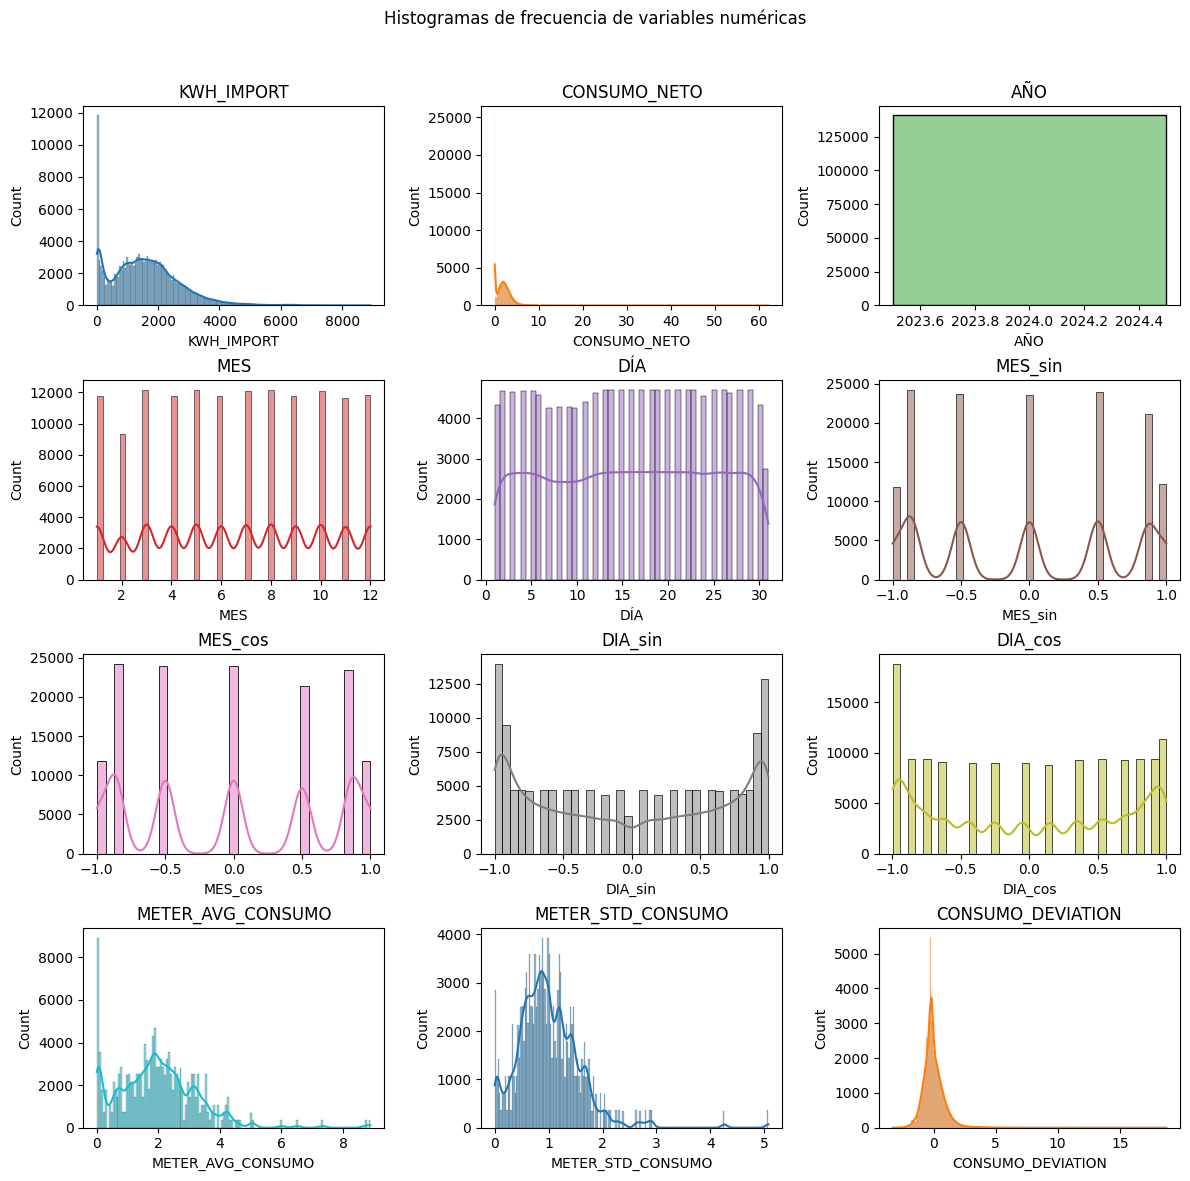

In [23]:
#Exploración univaridad de los datos
##Para datos numéricos: Histogramas de frecuencia
##Para datos categóricos: Gráficos de torta

###HISTOGRAMAS DE FRECUENCIA (Busca variables con distribución uniforme (id) o que no aportan información)
fig,ax = plt.subplots(4, 3, figsize=(12, 12))
ax = ax.flat
num_cols = data_mod_enhanced.select_dtypes(include=['int64', 'float64']).columns
for i, col in enumerate(num_cols):
    sb.histplot(data = data_mod_enhanced, x = col, kde = True, 
                color = (list(plt.rcParams['axes.prop_cycle'])*7)[i]['color'], ax = ax[i])
    ax[i].set_title(col)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.suptitle('Histogramas de frecuencia de variables numéricas')
plt.show()


### Factor de Correlación
Si el comportamiento de una variable depende linealmente de otra variable. -1 <= Factor correlacón <= 1
La fórmula del factor de correlación de Pearson es:

$$
r_{xy} = \frac{\sqrt{(X_1-\bar{X_1})^2(X_2-\bar{X_2})^2}}{\sqrt{(X_1-\bar{X_1})}\sqrt{(X_2-\bar{X_1})}}
$$

donde $x_i$ y $y_i$ son los valores de las variables, $\bar{x}$ y $\bar{y}$ sus medias, y $n$ el número de observaciones.

- *Factor de correlación > 0*: Correlación directa
- *Factor de correlación < 1*: Correlación inversa
- *-0.25 <= Factor de correlación <= 0.25*: Correlación nula
- *0.25 <= |Factor de correlación| <= 0.5*: Correlación débil
- *0.5 <= |Factor de correlación| <= 0.75*: Correlación moderada
- *0.75 <= |Factor de correlación| <= 1*: Correlación fuerte --> Multicolinealidad

> Si se presenta multicolinealidad, se debe ignorar una de las variables. Se ignora la que tenga mayor correlación con las otras variables.

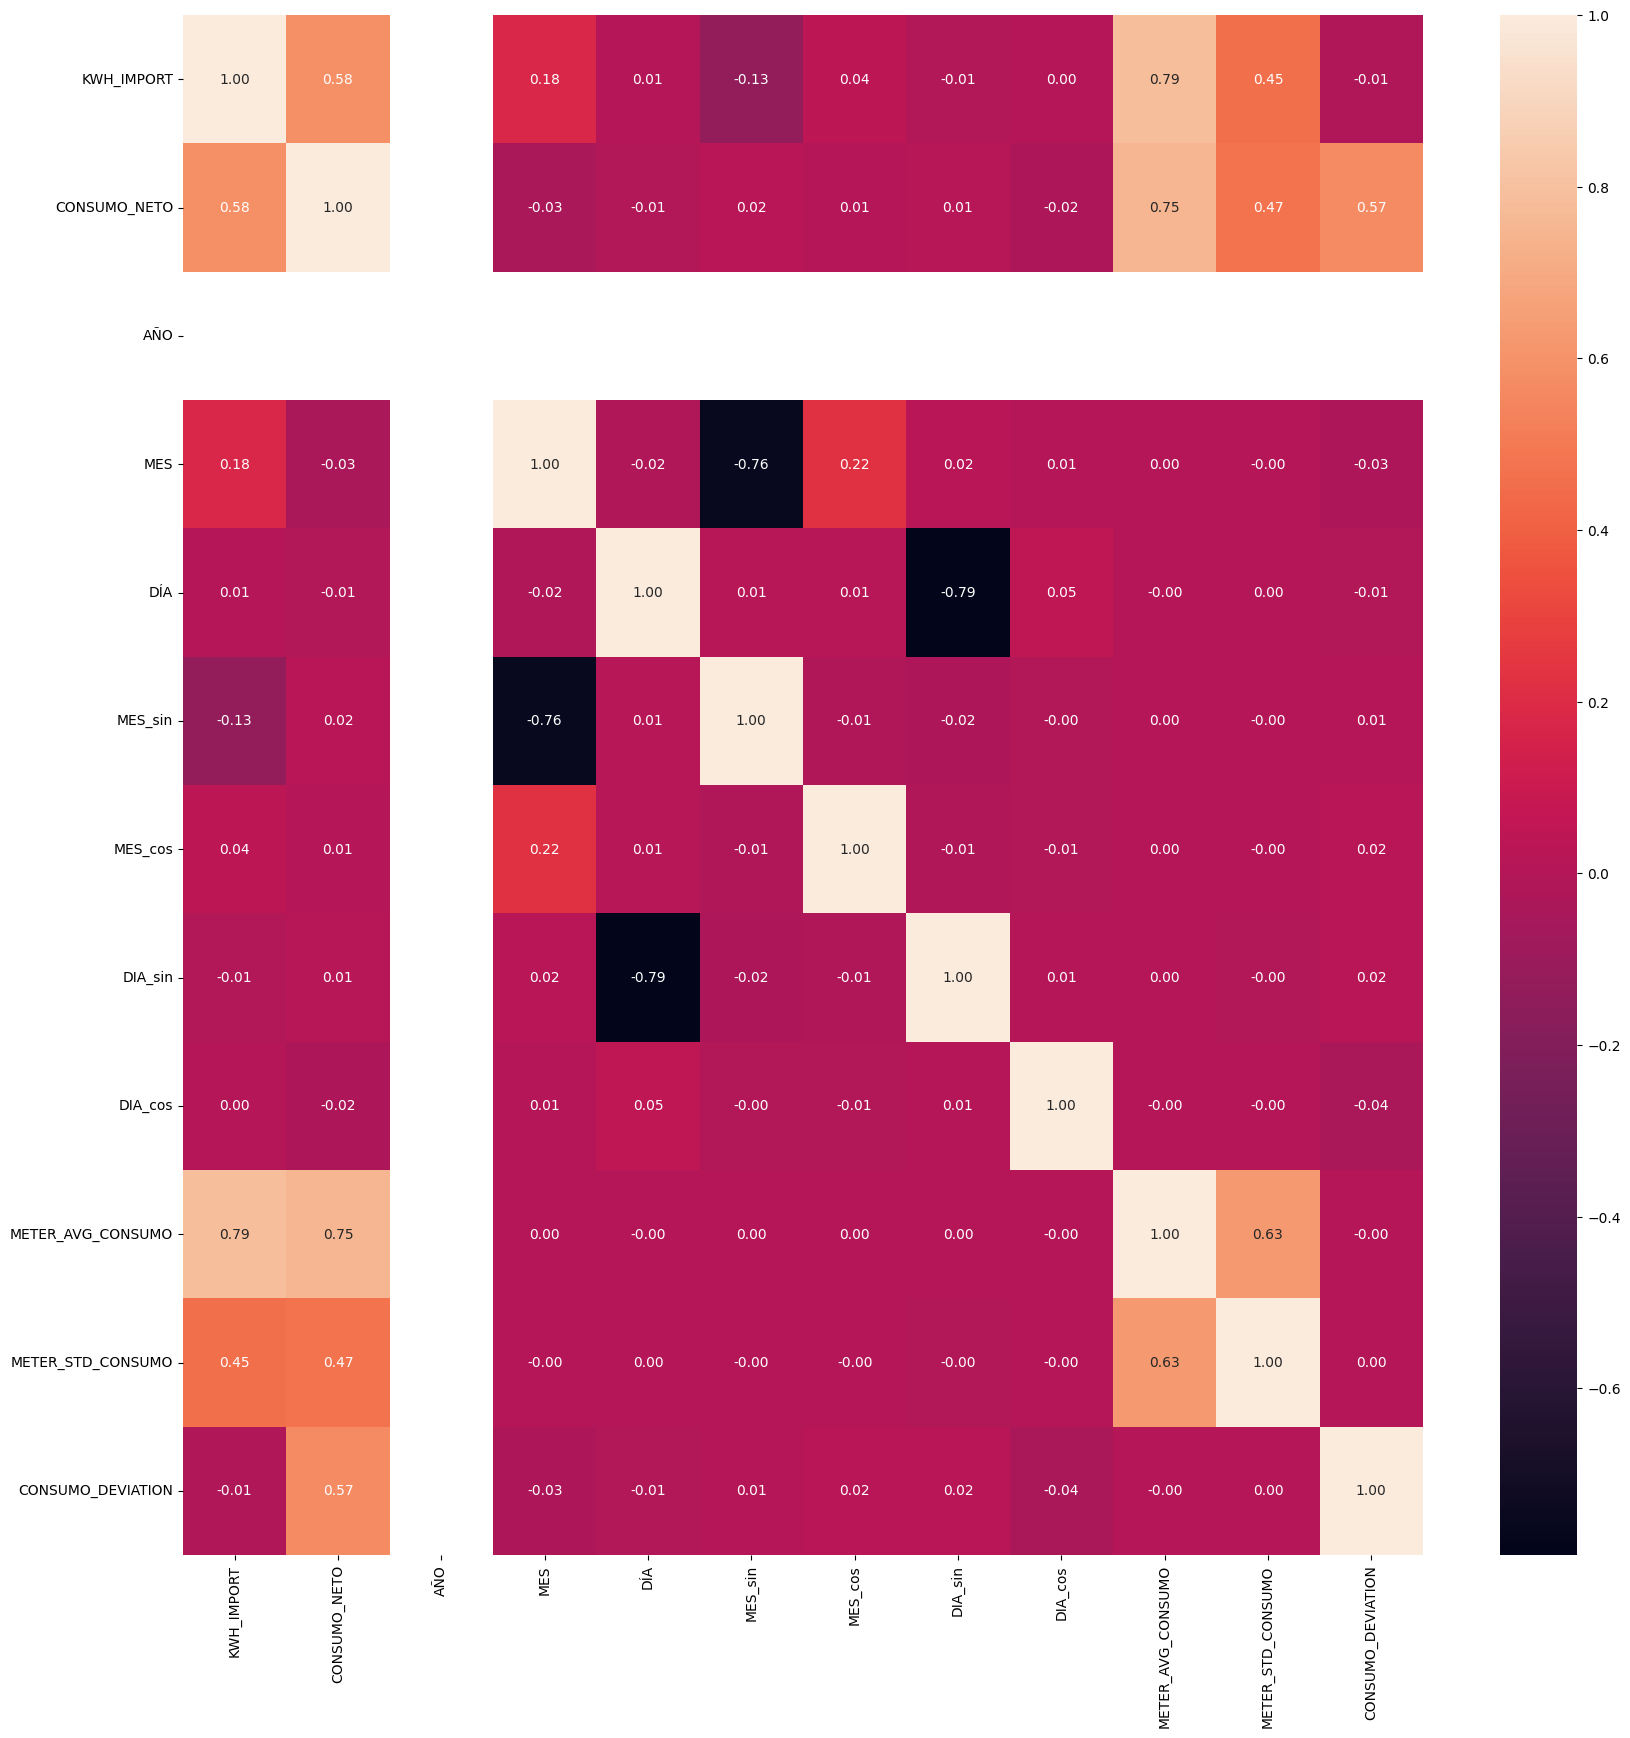

In [24]:
#GRÁFICO DE CORRELACIÓN PARA ANÁLISIS MULTIVARIADO (Busca multicolinealidad)
plt.figure(figsize=(20,20))
sb.heatmap(data = data_mod_enhanced.corr(numeric_only=True), annot=True, fmt='.2f')
plt.show()

### Conclusiones sobre Variables
- Ignorar FECHA --> Su información fue desagragada
- Ignorar AÑO --> Mismo valor para todos los registros
- Ignorar ID --> No aporta información al clustering
- Ignorar MES y DÍA originales --> Reemplazados por codificación circular
- Ignorar METER_AVG_CONSUMO --> Ya capturado en CONSUMO_DEVIATION y presenta colinealidad con Consumo_neto

6. Preparación de los Datos
- Activar las decisiones de ignorar variables
- Transformación de variables para que sean entendibles por el modelo

In [25]:
### Conclusiones sobre Variables
# - Ignorar FECHA --> Su información fue desagregada
# - Ignorar AÑO --> Mismo valor para todos los registros
# - Ignorar ID --> No aporta información al clustering
# - Ignorar MES y DÍA originales --> Reemplazados por codificación circular
# - Ignorar METER_AVG_CONSUMO --> Ya capturado en CONSUMO_DEVIATION

# 6. Preparación de los Datos

# Select final features (using data_mod_enhanced which has all engineered features)
data_final = data_mod_enhanced[[
    'CONSUMO_NETO',
    'MES_sin', 'MES_cos',
    'DIA_sin', 'DIA_cos',
    'METER_STD_CONSUMO',
    'CONSUMO_DEVIATION'
]].copy()

print(f"Features selected for clustering: {data_final.columns.tolist()}")
print(f"Shape: {data_final.shape}")
data_final.info()

Features selected for clustering: ['CONSUMO_NETO', 'MES_sin', 'MES_cos', 'DIA_sin', 'DIA_cos', 'METER_STD_CONSUMO', 'CONSUMO_DEVIATION']
Shape: (140628, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140628 entries, 0 to 140627
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CONSUMO_NETO       140628 non-null  float64
 1   MES_sin            140628 non-null  float64
 2   MES_cos            140628 non-null  float64
 3   DIA_sin            140628 non-null  float64
 4   DIA_cos            140628 non-null  float64
 5   METER_STD_CONSUMO  140628 non-null  float64
 6   CONSUMO_DEVIATION  140628 non-null  float64
dtypes: float64(7)
memory usage: 7.5 MB


In [26]:
# Transformación de variables
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# All features are numeric now
num_col = data_final.columns.to_list()

# Scale all numeric features
num_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

# Design column transformer
preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, num_col)],
    remainder='drop'
)

# Transform
data_pre = preprocessor.fit_transform(data_final)
data_pro = pd.DataFrame(data_pre, columns=num_col)

# IMPORTANT: Keep the index aligned with data_mod_enhanced
data_pro.index = data_final.index  # Preserve original indices

print(f"Preprocessed shape: {data_pro.shape}")
print(f"Index preserved: {data_pro.index.equals(data_final.index)}")
data_pro.head()

Preprocessed shape: (140628, 7)
Index preserved: True


,CONSUMO_NETO,MES_sin,MES_cos,DIA_sin,DIA_cos,METER_STD_CONSUMO,CONSUMO_DEVIATION
0,0.059792,0.75,0.933013,0.697431,0.959375,0.218506,0.118494
1,0.068005,0.75,0.933013,0.786001,0.910151,0.218506,0.139376
2,0.070207,0.75,0.933013,0.862862,0.844083,0.218506,0.144975
3,0.071621,0.75,0.933013,0.924867,0.763876,0.218506,0.148571
4,0.072136,0.75,0.933013,0.969479,0.672813,0.218506,0.149879


7. Construcción del modelo

**K Means**

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

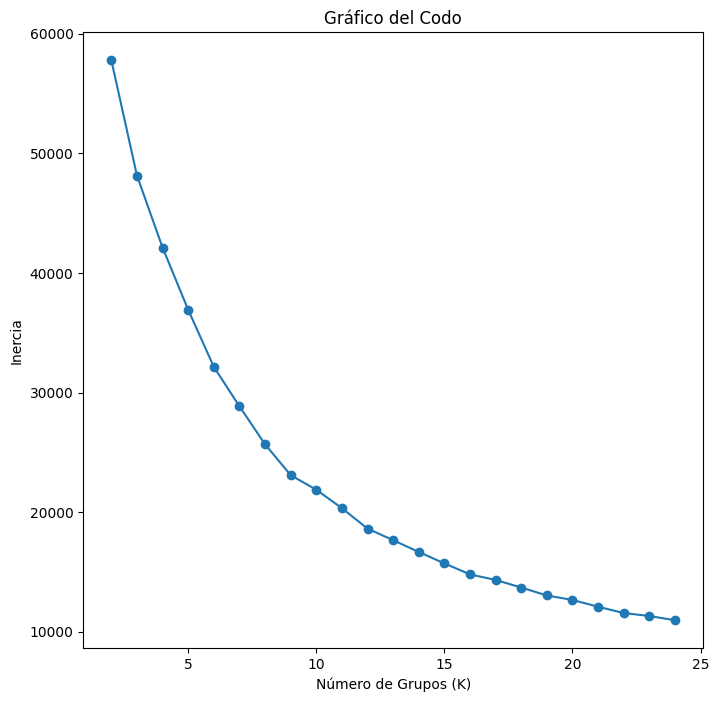

In [28]:
#Buscar el rango para K (busca el codo)
range_k = range(2, 25)
inertia = []

for n_clusters in range_k:
    kmean_model = KMeans(n_clusters=n_clusters, n_init=20, random_state=123)
    kmean_model.fit(data_pro)
    inertia.append(kmean_model.inertia_)
    
plt.figure(figsize=(8, 8))
plt.plot(range_k, inertia, marker='o')
plt.title("Gráfico del Codo")
plt.xlabel("Número de Grupos (K)")
plt.ylabel("Inercia")
plt.show()

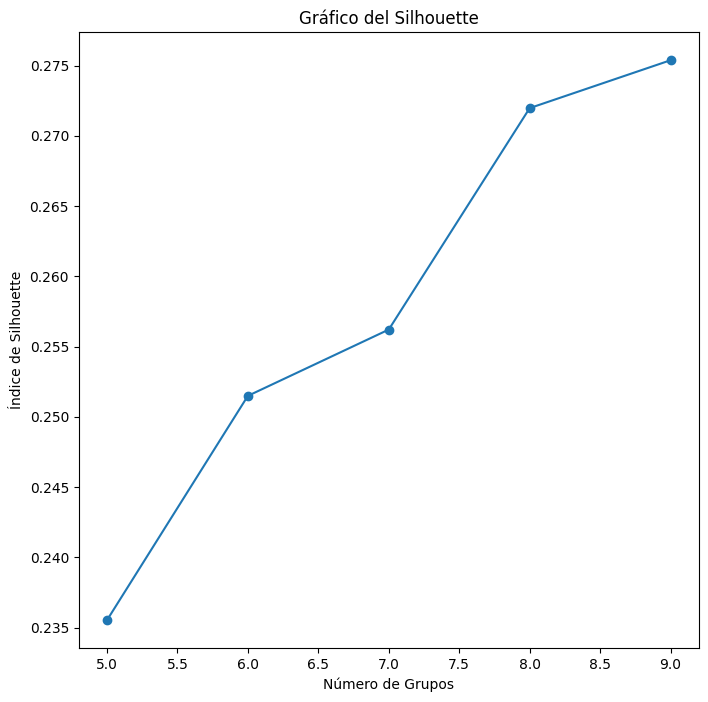

In [29]:
#Búsqueda fina de k (dado el rango de codo, toma el válor de max índice)
range_k = range(5, 10)
sil_score = []

for n_clusters in range_k:
    kmean_model = KMeans(n_clusters=n_clusters, n_init=20, random_state=123)
    kmean_model.fit(data_pro)
    cluster_label = kmean_model.fit_predict(data_pro)
    sil_avg = silhouette_score(data_pro, cluster_label)
    sil_score.append(sil_avg)
    
plt.figure(figsize=(8, 8))
plt.plot(range_k, sil_score, marker='o')
plt.title("Gráfico del Silhouette")
plt.xlabel("Número de Grupos")
plt.ylabel("Índice de Silhouette")
plt.show()

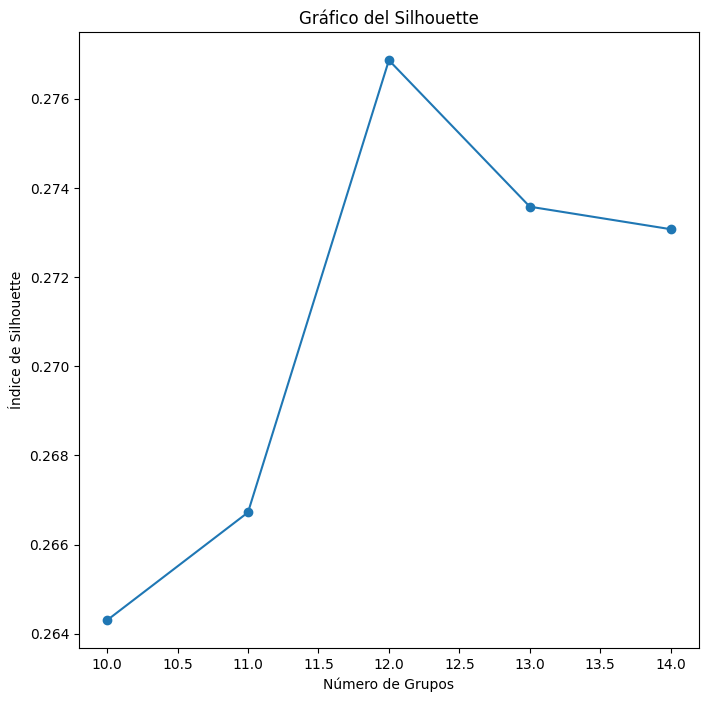

In [30]:
#Búsqueda fina de k (dado el rango de codo, toma el válor de max índice)
range_k = range(10, 15)
sil_score = []

for n_clusters in range_k:
    kmean_model = KMeans(n_clusters=n_clusters, n_init=20, random_state=123)
    kmean_model.fit(data_pro)
    cluster_label = kmean_model.fit_predict(data_pro)
    sil_avg = silhouette_score(data_pro, cluster_label)
    sil_score.append(sil_avg)
    
plt.figure(figsize=(8, 8))
plt.plot(range_k, sil_score, marker='o')
plt.title("Gráfico del Silhouette")
plt.xlabel("Número de Grupos")
plt.ylabel("Índice de Silhouette")
plt.show()

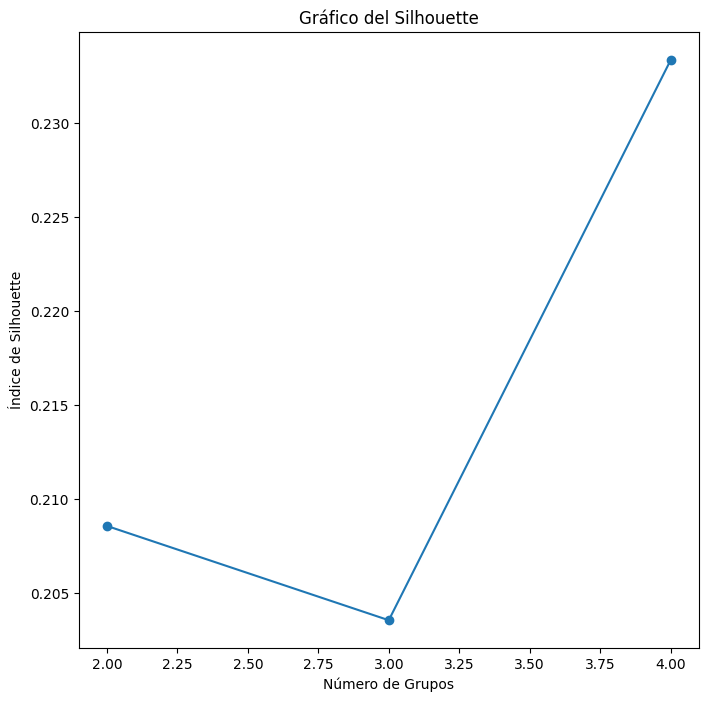

In [31]:
#Búsqueda fina de k (dado el rango de codo, toma el válor de max índice)
range_k = range(2, 5)
sil_score = []

for n_clusters in range_k:
    kmean_model = KMeans(n_clusters=n_clusters, n_init=20, random_state=123)
    kmean_model.fit(data_pro)
    cluster_label = kmean_model.fit_predict(data_pro)
    sil_avg = silhouette_score(data_pro, cluster_label)
    sil_score.append(sil_avg)
    
plt.figure(figsize=(8, 8))
plt.plot(range_k, sil_score, marker='o')
plt.title("Gráfico del Silhouette")
plt.xlabel("Número de Grupos")
plt.ylabel("Índice de Silhouette")
plt.show()

In [32]:
# Selección del número óptimo de clusters (Mayor índice de Silhouette observado: 12)
k_mean_model_final_1 = KMeans(n_clusters=12, n_init=20, random_state=123)
k_mean_model_final_1.fit(data_pro)

,n_clusters,12
,init,'k-means++'
,n_init,20
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,123
,copy_x,True
,algorithm,'lloyd'


In [33]:
# Selección de clústeres según literatura (entre 3 y 6 -> Se selecciona 5)
k_mean_model_final_2 = KMeans(n_clusters=5, n_init=20, random_state=123)
k_mean_model_final_2.fit(data_pro)

,n_clusters,5
,init,'k-means++'
,n_init,20
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,123
,copy_x,True
,algorithm,'lloyd'


**Jerárquico Aglomerativo (Para hallar número de clústers)**

**MiniBatchKMeans (Modelo entrenado con clústeres de Jerárquico Aglomerativo)**

In [34]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

#Función para dibujar el dendrograma
def dibujarDendrograma(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
 
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
 
    # Plot
    dendrogram(linkage_matrix, **kwargs)

In [35]:
# === SAMPLE DATA FOR DENDROGRAM VISUALIZATION ===
sample_size = 1500  # Adjust based on your RAM (1000-2000 recommended)
np.random.seed(123)  # For reproducibility
data_pro_sample = data_pro.sample(n=sample_size, random_state=123)

print(f"Sampled {sample_size} rows for dendrogram visualization")
print(f"Original dataset: {len(data_pro)} rows")
print(f"Sample represents: {(sample_size/len(data_pro)*100):.1f}% of data")

Sampled 1500 rows for dendrogram visualization
Original dataset: 140628 rows
Sample represents: 1.1% of data


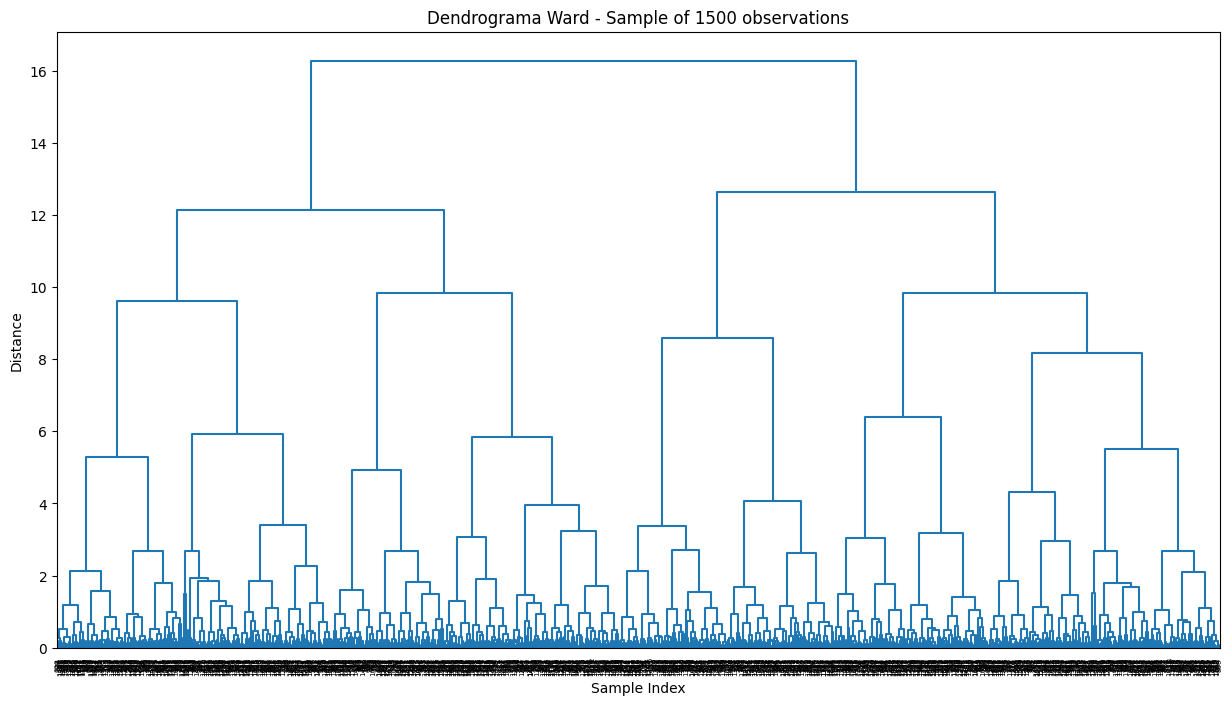

In [36]:
# Cell 45: Varianza (Ward linkage) - Using SAMPLED data
h_clust_ward_sample = AgglomerativeClustering(
    metric='euclidean', 
    linkage='ward', 
    distance_threshold=0,  # Compute full tree
    n_clusters=None,
    compute_distances=True  # Required for dendrogram
)

h_clust_ward_sample.fit(X=data_pro_sample)

# Draw dendrogram
plt.figure(figsize=(15, 8))
dibujarDendrograma(h_clust_ward_sample, color_threshold=0)
plt.title(f'Dendrograma Ward - Sample of {sample_size} observations')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

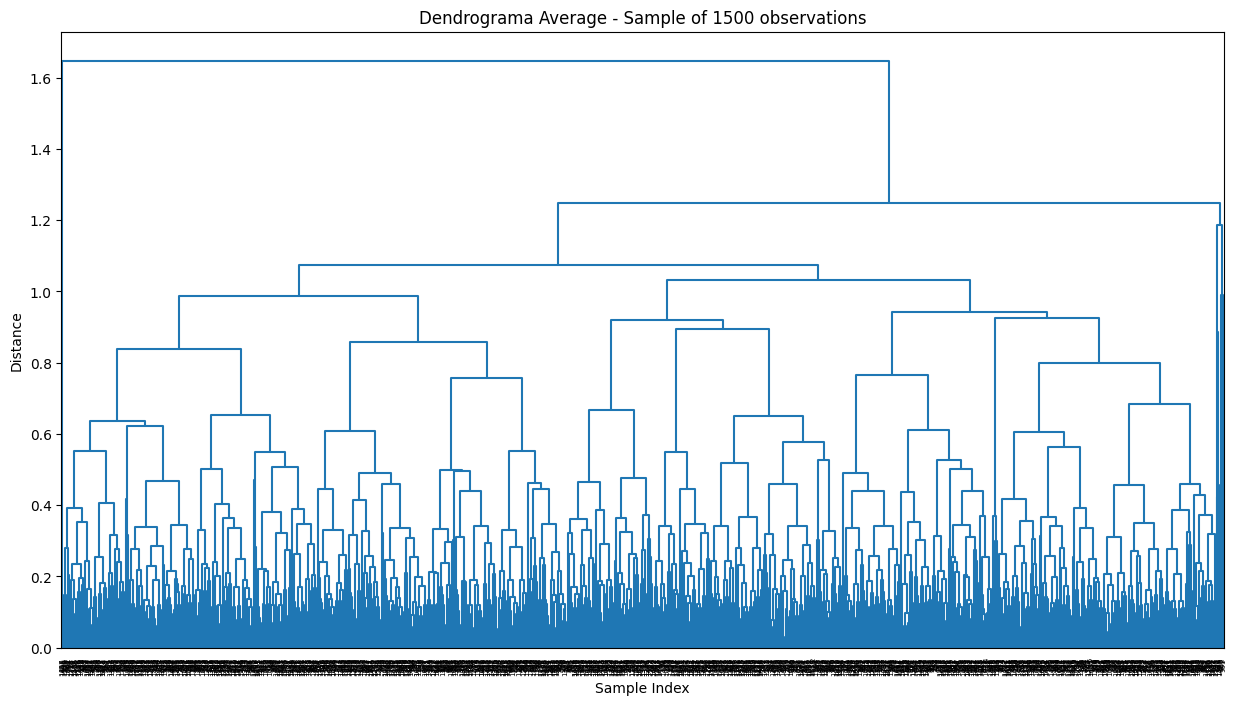

In [37]:
# Cell 46: Promedio (Average linkage) - Using SAMPLED data
h_clust_average_sample = AgglomerativeClustering(
    metric='euclidean', 
    linkage='average', 
    distance_threshold=0,
    n_clusters=None,
    compute_distances=True
)

h_clust_average_sample.fit(X=data_pro_sample)

plt.figure(figsize=(15, 8))
dibujarDendrograma(h_clust_average_sample, color_threshold=0)
plt.title(f'Dendrograma Average - Sample of {sample_size} observations')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

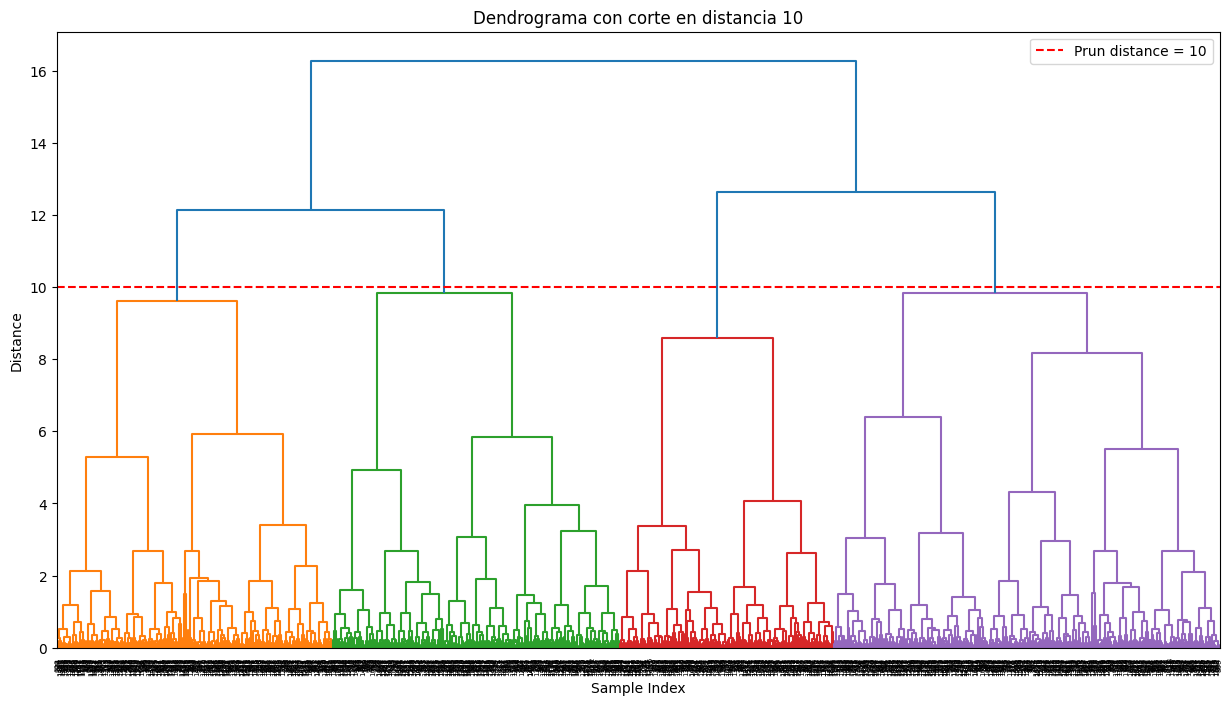

At prun distance 10, approximately 1500 clusters would form (in sample)


In [38]:
# Cell 47: Visualize with color threshold (to choose prun distance)
dendogram_prun = 10  # Adjust after seeing the dendrogram above

plt.figure(figsize=(15, 8))
dibujarDendrograma(h_clust_ward_sample, color_threshold=dendogram_prun)
plt.axhline(y=dendogram_prun, color='r', linestyle='--', label=f'Prun distance = {dendogram_prun}')
plt.title(f'Dendrograma con corte en distancia {dendogram_prun}')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.legend()
plt.show()

# Count approximate clusters at this threshold
n_clusters_approx = len(set([c for c in h_clust_ward_sample.labels_]))
print(f"At prun distance {dendogram_prun}, approximately {n_clusters_approx} clusters would form (in sample)")

In [39]:
from sklearn.cluster import MiniBatchKMeans

# Use MiniBatchKMeans as a scalable alternative to hierarchical clustering
mini_batch_kmeans = MiniBatchKMeans(
    n_clusters=4,  # Based on dendrogram visual analysis
    batch_size=1000,
    n_init=20, 
    random_state=123
)

print(f"Training MiniBatchKMeans on FULL dataset ({len(data_pro)} rows) with k=4")
mini_batch_kmeans.fit(data_pro)
print(f"✓ Model trained successfully!")

labels_mini_kmeans = mini_batch_kmeans.labels_
print(f"Cluster distribution: {np.bincount(labels_mini_kmeans)}")

Training MiniBatchKMeans on FULL dataset (140628 rows) with k=4
✓ Model trained successfully!
Cluster distribution: [35835 34611 33952 36230]


**Birch**

In [40]:
# === FIND THRESHOLD THAT PRODUCES 4 CLUSTERS ===
from sklearn.cluster import Birch


print("🔍 Testing BIRCH thresholds to get exactly 4 clusters:\n")
print(f"{'Threshold':<12} {'Subclusters':<14} {'Final Clusters':<16} {'Silhouette':<12}")
print("-" * 60)

thresholds_test = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
birch_configs = []

for t in thresholds_test:
    birch_test = Birch(n_clusters=4, threshold=t, branching_factor=50)
    birch_test.fit(data_pro)
    labels_test = birch_test.labels_
    
    n_subclusters = len(birch_test.subcluster_centers_)
    n_final = len(np.unique(labels_test))
    
    # Calculate silhouette if valid clustering
    if n_final > 1:
        sil = silhouette_score(data_pro, labels_test)
        print(f"{t:<12.2f} {n_subclusters:<14} {n_final:<16} {sil:<12.3f}")
        
        birch_configs.append({
            'threshold': t,
            'subclusters': n_subclusters,
            'final_clusters': n_final,
            'silhouette': sil,
            'labels': labels_test
        })
    else:
        print(f"{t:<12.2f} {n_subclusters:<14} {n_final:<16} {'Invalid':<12}")

# Find best config with exactly 4 clusters
configs_with_4 = [c for c in birch_configs if c['final_clusters'] == 4]

if configs_with_4:
    best_config = max(configs_with_4, key=lambda x: x['silhouette'])
    
    print(f"\n✅ FOUND: threshold={best_config['threshold']:.2f} produces 4 clusters")
    print(f"   Silhouette: {best_config['silhouette']:.3f}")
    print(f"   Subclusters in CF-Tree: {best_config['subclusters']}")
    
    # Retrain final model with best threshold
    birch_final = Birch(
        n_clusters=4,
        threshold=best_config['threshold'],
        branching_factor=50
    )
    birch_final.fit(data_pro)
    labels_birch = birch_final.labels_
    
    print(f"\n📊 Final BIRCH cluster distribution:")
    for i, count in enumerate(np.bincount(labels_birch)):
        print(f"   Cluster {i}: {count:>6} ({count/len(labels_birch)*100:>5.1f}%)")
    
else:
    print(f"\n⚠️  WARNING: No threshold produced exactly 4 clusters!")
    print(f"   Closest results:")
    for c in sorted(birch_configs, key=lambda x: abs(x['final_clusters'] - 4))[:3]:
        print(f"   - threshold={c['threshold']:.2f}: {c['final_clusters']} clusters (sil={c['silhouette']:.3f})")
    
    print(f"\n💡 RECOMMENDATION: Use MiniBatchKMeans instead (already gives balanced 4 clusters)")

🔍 Testing BIRCH thresholds to get exactly 4 clusters:

Threshold    Subclusters    Final Clusters   Silhouette  
------------------------------------------------------------
0.10         1704           4                0.148       
0.15         674            4                0.152       
0.20         358            4                0.115       
0.25         164            4                0.138       
0.30         112            4                0.146       
0.35         24             4                0.160       
0.40         20             4                0.177       
0.45         14             4                0.168       
0.50         14             4                0.161       
0.55         16             4                0.188       
0.60         6              4                0.165       

✅ FOUND: threshold=0.55 produces 4 clusters
   Silhouette: 0.188
   Subclusters in CF-Tree: 16

📊 Final BIRCH cluster distribution:
   Cluster 0:  37587 ( 26.7%)
   Cluster 1:  36755 ( 26

In [41]:
# === DIAGNOSE BIRCH BEHAVIOR ===

print(f"BIRCH Configuration:")
print(f"  Requested clusters: {birch_final.n_clusters}")
print(f"  Actual clusters found: {len(np.unique(labels_birch))}")
print(f"  Threshold: {birch_final.threshold}")
print(f"  Branching factor: {birch_final.branching_factor}")

print(f"\nCluster distribution:")
for i, count in enumerate(np.bincount(labels_birch)):
    print(f"  Cluster {i}: {count:>6} ({count/len(labels_birch)*100:>5.1f}%)")

# Check if BIRCH's subclusters were merged
print(f"\nNumber of subclusters in CF-Tree: {len(birch_final.subcluster_centers_)}")
print(f"Number of final clusters: {len(np.unique(labels_birch))}")

BIRCH Configuration:
  Requested clusters: 4
  Actual clusters found: 4
  Threshold: 0.55
  Branching factor: 50

Cluster distribution:
  Cluster 0:  37587 ( 26.7%)
  Cluster 1:  36755 ( 26.1%)
  Cluster 2:  30728 ( 21.9%)
  Cluster 3:  35558 ( 25.3%)

Number of subclusters in CF-Tree: 16
Number of final clusters: 4


**DBScan**

In [42]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from itertools import product

🔍 Tuning DBSCAN on sample of 5000 rows...
   (will apply best params to full 140628 rows later)



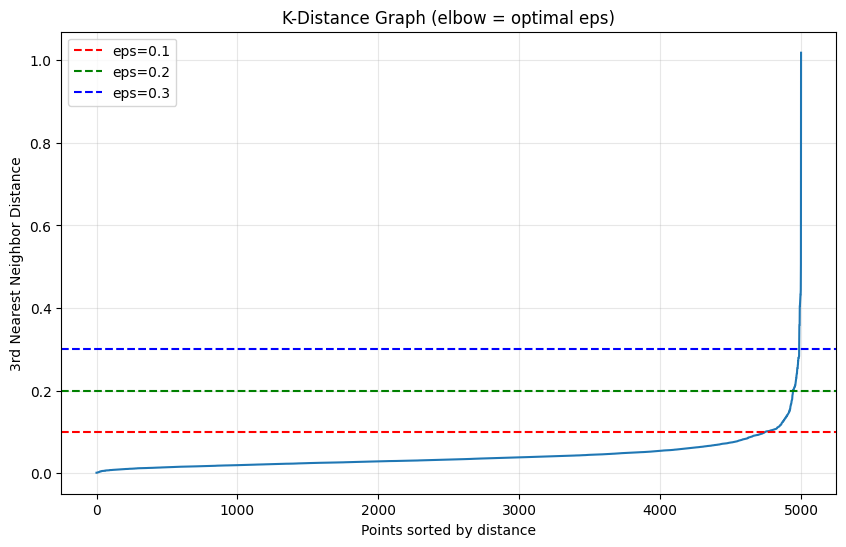

In [43]:
# === OPTIMIZED DBSCAN TUNING (avoids memory crash) ===

# Step 1: Use SAMPLE for parameter search
sample_size = 5000  # Large enough for representative results
np.random.seed(123)
data_pro_dbscan_sample = data_pro.sample(n=sample_size, random_state=123)

print(f"🔍 Tuning DBSCAN on sample of {sample_size} rows...")
print(f"   (will apply best params to full {len(data_pro)} rows later)\n")

# Step 2: Find optimal eps from k-distance graph (on sample)
neighbors = NearestNeighbors(n_neighbors=3)
neighbors_fit = neighbors.fit(data_pro_dbscan_sample)
distances, indices = neighbors_fit.kneighbors(data_pro_dbscan_sample)

# Sort distances to find elbow
distances = np.sort(distances[:, 1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=0.1, color='r', linestyle='--', label='eps=0.1')
plt.axhline(y=0.2, color='g', linestyle='--', label='eps=0.2')
plt.axhline(y=0.3, color='b', linestyle='--', label='eps=0.3')
plt.xlabel('Points sorted by distance')
plt.ylabel('3rd Nearest Neighbor Distance')
plt.title('K-Distance Graph (elbow = optimal eps)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [44]:

# Step 3: Reduced parameter grid (avoid memory explosion)
eps_values = np.arange(0.1, 0.5, 0.05)  # Fewer values
min_samples_values = [2, 3, 5, 10]  # Fewer values

print("Testing parameter combinations on SAMPLE...")
print(f"{'eps':<8} {'min_samp':<10} {'Clusters':<10} {'Noise %':<10} {'Silhouette':<12}")
print("-" * 60)

best_score = -1
best_params = None
dbscan_results = []

for eps in eps_values:
    for min_samp in min_samples_values:
        # Fit on SAMPLE
        dbscan_temp = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan_temp.fit_predict(data_pro_dbscan_sample)
        
        # Calculate metrics
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = (n_noise / len(labels)) * 100
        
        # Silhouette only if we have clusters (not all noise)
        if n_clusters > 1 and n_noise < len(labels) * 0.9:  # Max 90% noise
            score = silhouette_score(data_pro_dbscan_sample, labels)
            
            print(f"{eps:<8.2f} {min_samp:<10} {n_clusters:<10} {noise_pct:<10.1f} {score:<12.3f}")
            
            dbscan_results.append({
                'eps': eps,
                'min_samples': min_samp,
                'n_clusters': n_clusters,
                'noise_pct': noise_pct,
                'silhouette': score
            })
            
            # Track best (balance silhouette and reasonable noise %)
            if score > best_score and noise_pct < 20:  # Max 20% noise acceptable
                best_score = score
                best_params = (eps, min_samp)
        else:
            print(f"{eps:<8.2f} {min_samp:<10} {n_clusters:<10} {noise_pct:<10.1f} {'N/A':<12} (too noisy)")

print(f"\n✓ Best parameters: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"  Silhouette Score: {best_score:.3f}")

Testing parameter combinations on SAMPLE...
eps      min_samp   Clusters   Noise %    Silhouette  
------------------------------------------------------------
0.10     2          431        5.1        0.203       
0.10     3          390        6.7        0.187       
0.10     5          348        12.4       0.143       
0.10     10         169        53.1       -0.227      
0.15     2          27         1.6        -0.162      
0.15     3          14         2.2        0.037       
0.15     5          14         2.4        0.036       
0.15     10         13         3.0        0.034       
0.20     2          16         1.1        0.008       
0.20     3          14         1.2        0.039       
0.20     5          14         1.4        0.038       
0.20     10         13         1.7        0.037       
0.25     2          17         0.6        0.040       
0.25     3          14         0.7        0.042       
0.25     5          14         0.7        0.042       
0.25     10    

In [45]:
# === TRAIN FINAL DBSCAN ON FULL DATASET ===

dbscan_final = DBSCAN(eps=best_params[0], min_samples=best_params[1], n_jobs=-1)

print(f"\n🚀 Training DBSCAN on FULL dataset ({len(data_pro)} rows)...")
print(f"   Parameters: eps={best_params[0]}, min_samples={best_params[1]}")

dbscan_final.fit(data_pro)

labels_dbscan = dbscan_final.labels_
n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"✓ Model trained successfully!")
print(f"\nResults on FULL data:")
print(f"  Clusters found: {n_clusters}")
print(f"  Noise points: {n_noise} ({n_noise/len(data_pro)*100:.1f}%)")
print(f"  Cluster distribution: {np.bincount(labels_dbscan[labels_dbscan >= 0])}")


🚀 Training DBSCAN on FULL dataset (140628 rows)...
   Parameters: eps=0.1, min_samples=2
✓ Model trained successfully!

Results on FULL data:
  Clusters found: 415
  Noise points: 981 (0.7%)
  Cluster distribution: [387 388 387 387 388 388 389 387 389 387 386 388 387 387 388 385 380 384
 388 389 390 390 389 390 391 390 391 391 390 391 391 390 350 376 372  94
 353 371 389 390 390 390 390 391 391 391 391 391 391 391 391 391 391 391
 391 390 390 390 388 390 391 390 391 390 391 391 390 391 391 390 391 391
 391 390 391 390 391 389 391 389 391 389 390 389 388 391 391 391 391 390
 391 390 390 390 391 391 390 391 391 391 391 391 391 391 391 391 390 390
 391 390 390 391 391 389 391 391 390 391 391 390 390 391 390 391 391 390
 390 391 391 391 391 391 390 391 391 391 391 391 391 391 391 391 391 391
 390 391 391 391 390 390 390 391 390 390 390 391 391 390 391 390 391 391
 391 391 390 391 391 391 391 391 391 391 391 390 388 391 390 390 388 389
 389 390 389 389 388 356 353 363 377 390 388 389 390 3

In [46]:
dbscan_final

,eps,np.float64(0.1)
,min_samples,2
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,-1


**Gaussian Mixture Models (GMM)**

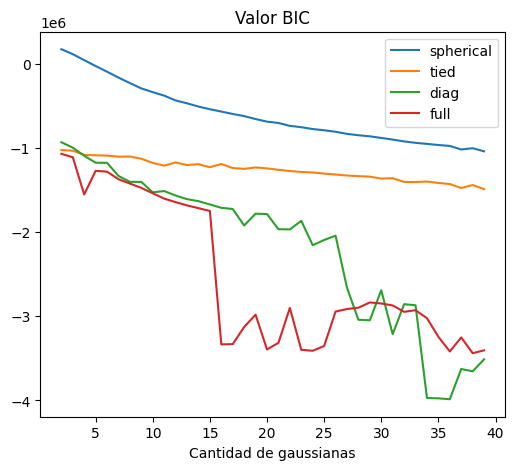

In [47]:
from sklearn.mixture import GaussianMixture
fig, ax = plt.subplots(figsize=(6,5))
n_gauss = range(2, 40)
var_types = ['spherical', 'tied', 'diag', 'full']
''' Spherical: La proyección en 2D es un círculo, la varianza es la misma en todas las direcciones.
    Tied: Misma varianza para todas las gaussianas
    Diagonal: Varianza según una de las variables o características de los datos
    Full: Deja libre la varianza de cada gaussiana, es decir, cada gaussiana puede tener una forma diferente.'''
for covariance_type in var_types:
    valor_bic = []
    for i in n_gauss:
        modelo = GaussianMixture(n_components=i, covariance_type=covariance_type, random_state=123)
        modelo.fit(data_pro)
        valor_bic.append(modelo.bic(data_pro))
        
    ax.plot(n_gauss, valor_bic, label=covariance_type)
ax.set_title('Valor BIC')
ax.set_xlabel('Cantidad de gaussianas')
ax.legend()
plt.show()
#Se debe serleccionar el mínimo BIC (eje Y) y el número de gaussianas (eje X) que lo produce.

In [48]:
gmm_final = GaussianMixture(n_components=15, covariance_type='full', random_state=123)
gmm_final.fit(data_pro)

,n_components,15
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,123


8. Evaluación del Modelo

In [49]:
# Get labels from all models
labels_kmeans_1 = k_mean_model_final_1.predict(data_pro)  # k=12
labels_kmeans_2 = k_mean_model_final_2.predict(data_pro)  # k=5
labels_hclust = mini_batch_kmeans.labels_  # Using MiniBatchKMeans as hierarchical alternative
labels_birch = birch_final.labels_
labels_dbscan = dbscan_final.fit_predict(data_pro)
labels_gmm = gmm_final.predict(data_pro)

In [50]:
# Calculate silhouette scores
sil_kmeans_1 = silhouette_score(data_pro, labels_kmeans_1)
sil_kmeans_2 = silhouette_score(data_pro, labels_kmeans_2)
sil_hclust = silhouette_score(data_pro, labels_hclust)
sil_birch = silhouette_score(data_pro, labels_birch)
sil_dbscan = silhouette_score(data_pro, labels_dbscan)
sil_gmm = silhouette_score(data_pro, labels_gmm)

print(f'El índice de Silhouette para:')
print(f'KMeans (k=12)    = {sil_kmeans_1:.3f}')
print(f'KMeans (k=5)     = {sil_kmeans_2:.3f}')
print(f'MiniBatch (k=4)  = {sil_hclust:.3f}')
print(f'BIRCH (k=4)      = {sil_birch:.3f}')
print(f'DBSCAN           = {sil_dbscan:.3f}')
print(f'GMM (n=15)       = {sil_gmm:.3f}')

El índice de Silhouette para:
KMeans (k=12)    = 0.277
KMeans (k=5)     = 0.236
MiniBatch (k=4)  = 0.232
BIRCH (k=4)      = 0.188
DBSCAN           = 0.240
GMM (n=15)       = 0.256


In [51]:
# Display cluster counts
print(f'\nDistribución de clusters:\n')
print(f'KMeans (k=12):   {np.bincount(labels_kmeans_1)}')
print(f'KMeans (k=5):    {np.bincount(labels_kmeans_2)}')
print(f'MiniBatch (k=4): {np.bincount(labels_hclust)}')
print(f'BIRCH (k=4):     {np.bincount(labels_birch)}')

# DBSCAN - Show noise separately
n_noise_dbscan = (labels_dbscan == -1).sum()
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)

print(f'\nDBSCAN:')
print(f'  Noise (-1):      {n_noise_dbscan:>6} ({n_noise_dbscan/len(labels_dbscan)*100:>5.1f}%)')
if n_clusters_dbscan > 0:
    cluster_counts = np.bincount(labels_dbscan[labels_dbscan >= 0])
    for i, count in enumerate(cluster_counts):
        print(f'  Cluster {i}:       {count:>6} ({count/len(labels_dbscan)*100:>5.1f}%)')
    print(f'  Total clusters:  {n_clusters_dbscan}')

print(f'\nGMM (n=15):      {np.bincount(labels_gmm)}')


Distribución de clusters:

KMeans (k=12):   [ 9930 12572 11781 10898 12183 11777 12969 11788 10994 11913 12179 11644]
KMeans (k=5):    [29967 30216 25437 29395 25613]
MiniBatch (k=4): [35835 34611 33952 36230]
BIRCH (k=4):     [37587 36755 30728 35558]

DBSCAN:
  Noise (-1):         981 (  0.7%)
  Cluster 0:          387 (  0.3%)
  Cluster 1:          388 (  0.3%)
  Cluster 2:          387 (  0.3%)
  Cluster 3:          387 (  0.3%)
  Cluster 4:          388 (  0.3%)
  Cluster 5:          388 (  0.3%)
  Cluster 6:          389 (  0.3%)
  Cluster 7:          387 (  0.3%)
  Cluster 8:          389 (  0.3%)
  Cluster 9:          387 (  0.3%)
  Cluster 10:          386 (  0.3%)
  Cluster 11:          388 (  0.3%)
  Cluster 12:          387 (  0.3%)
  Cluster 13:          387 (  0.3%)
  Cluster 14:          388 (  0.3%)
  Cluster 15:          385 (  0.3%)
  Cluster 16:          380 (  0.3%)
  Cluster 17:          384 (  0.3%)
  Cluster 18:          388 (  0.3%)
  Cluster 19:          389 (

9. Análisis del Mejor Modelo: K-Means k = 5

In [55]:
#Métricas de desempeño
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

print("=" * 70)
print("ANÁLISIS DEL MEJOR MODELO: K-MEANS (k=5)")
print("=" * 70)

# Get labels and predictions
labels_best = labels_kmeans_2  # k=5 model
sil_best = sil_kmeans_2

# Performance metrics

db_score = davies_bouldin_score(data_pro, labels_best)
ch_score = calinski_harabasz_score(data_pro, labels_best)

print(f"\nMÉTRICAS DE DESEMPEÑO:")
print(f"   • Silhouette Score:        {sil_best:.4f}  (Rango: -1 a 1, mejor cercano a 1)")
print(f"   • Davies-Bouldin Index:    {db_score:.4f}  (Menor es mejor)")
print(f"   • Calinski-Harabasz Score: {ch_score:.2f}  (Mayor es mejor)")

print(f"\nDISTRIBUCIÓN DE CLUSTERS:")
cluster_counts = np.bincount(labels_best)
for i, count in enumerate(cluster_counts):
    pct = (count / len(labels_best)) * 100
    print(f"   Cluster {i}: {count:>6} muestras ({pct:>5.1f}%)")

ANÁLISIS DEL MEJOR MODELO: K-MEANS (k=5)

MÉTRICAS DE DESEMPEÑO:
   • Silhouette Score:        0.2355  (Rango: -1 a 1, mejor cercano a 1)
   • Davies-Bouldin Index:    6.2939  (Menor es mejor)
   • Calinski-Harabasz Score: 18328.84  (Mayor es mejor)

DISTRIBUCIÓN DE CLUSTERS:
   Cluster 0:  29967 muestras ( 21.3%)
   Cluster 1:  30216 muestras ( 21.5%)
   Cluster 2:  25437 muestras ( 18.1%)
   Cluster 3:  29395 muestras ( 20.9%)
   Cluster 4:  25613 muestras ( 18.2%)


In [56]:
# Añadir etiquetas de clúster al dataset original
data_clustered = data_mod_enhanced.copy()
data_clustered['CLUSTER'] = labels_best

print(f"\nLabels agregados a dataset original")
print(f"  Total muestras: {len(data_clustered)}")
print(f"  Total medidores: {data_clustered['ID'].nunique()}")



Labels agregados a dataset original
  Total muestras: 140628
  Total medidores: 393


In [57]:
# Estadísticas por grupo
print(f"\nESTADÍSTICAS POR CLUSTER:")
print(f"\n{'Cluster':<10} {'Consumo Promedio':<18} {'Desv. Estándar':<18} {'Medidores':<12}")
print("-" * 70)

cluster_stats = []
for cluster_id in range(5):
    cluster_data = data_clustered[data_clustered['CLUSTER'] == cluster_id]
    
    avg_consumo = cluster_data['CONSUMO_NETO'].mean()
    std_consumo = cluster_data['CONSUMO_NETO'].std()
    n_meters = cluster_data['ID'].nunique()
    
    cluster_stats.append({
        'cluster': cluster_id,
        'avg_consumo': avg_consumo,
        'std_consumo': std_consumo,
        'n_meters': n_meters,
        'n_samples': len(cluster_data)
    })
    
    print(f"Cluster {cluster_id:<4} {avg_consumo:>12.2f} kWh    {std_consumo:>12.2f} kWh    {n_meters:>8}")

cluster_stats_df = pd.DataFrame(cluster_stats)



ESTADÍSTICAS POR CLUSTER:

Cluster    Consumo Promedio   Desv. Estándar     Medidores   
----------------------------------------------------------------------
Cluster 0            1.95 kWh            1.65 kWh         393
Cluster 1            2.09 kWh            2.07 kWh         393
Cluster 2            1.95 kWh            1.59 kWh         393
Cluster 3            1.95 kWh            1.60 kWh         393
Cluster 4            1.98 kWh            1.77 kWh         393


In [58]:
# Medidor representativo de cada grupo
print(f"\nSELECCIONANDO MEDIDOR REPRESENTATIVO DE CADA CLUSTER...")

representative_meters = []
for cluster_id in range(5):
    cluster_data = data_clustered[data_clustered['CLUSTER'] == cluster_id]
    
    # Get meter closest to cluster mean consumption
    cluster_mean = cluster_data['CONSUMO_NETO'].mean()
    meter_avg = cluster_data.groupby('ID')['CONSUMO_NETO'].mean()
    
    # Find meter with consumption closest to cluster mean
    closest_meter = (meter_avg - cluster_mean).abs().idxmin()
    
    # Ensure meter has at least 7 days of data
    meter_data = cluster_data[cluster_data['ID'] == closest_meter].sort_values('FECHA')
    
    if len(meter_data) >= 7:
        representative_meters.append({
            'cluster': cluster_id,
            'meter_id': closest_meter,
            'n_samples': len(meter_data),
            'avg_consumo': meter_data['CONSUMO_NETO'].mean()
        })
        print(f"   Cluster {cluster_id}: {closest_meter} ({len(meter_data)} muestras)")
    else:
        # Find alternative with more data
        for meter_id in meter_avg.sort_values(key=lambda x: abs(x - cluster_mean)).index:
            alt_data = cluster_data[cluster_data['ID'] == meter_id]
            if len(alt_data) >= 7:
                representative_meters.append({
                    'cluster': cluster_id,
                    'meter_id': meter_id,
                    'n_samples': len(alt_data),
                    'avg_consumo': alt_data['CONSUMO_NETO'].mean()
                })
                print(f"   Cluster {cluster_id}: {meter_id} ({len(alt_data)} muestras)")
                break



SELECCIONANDO MEDIDOR REPRESENTATIVO DE CADA CLUSTER...
   Cluster 0: MED_188 (68 muestras)
   Cluster 1: MED_86 (77 muestras)
   Cluster 2: MED_201 (65 muestras)
   Cluster 3: MED_299 (75 muestras)
   Cluster 4: MED_380 (65 muestras)


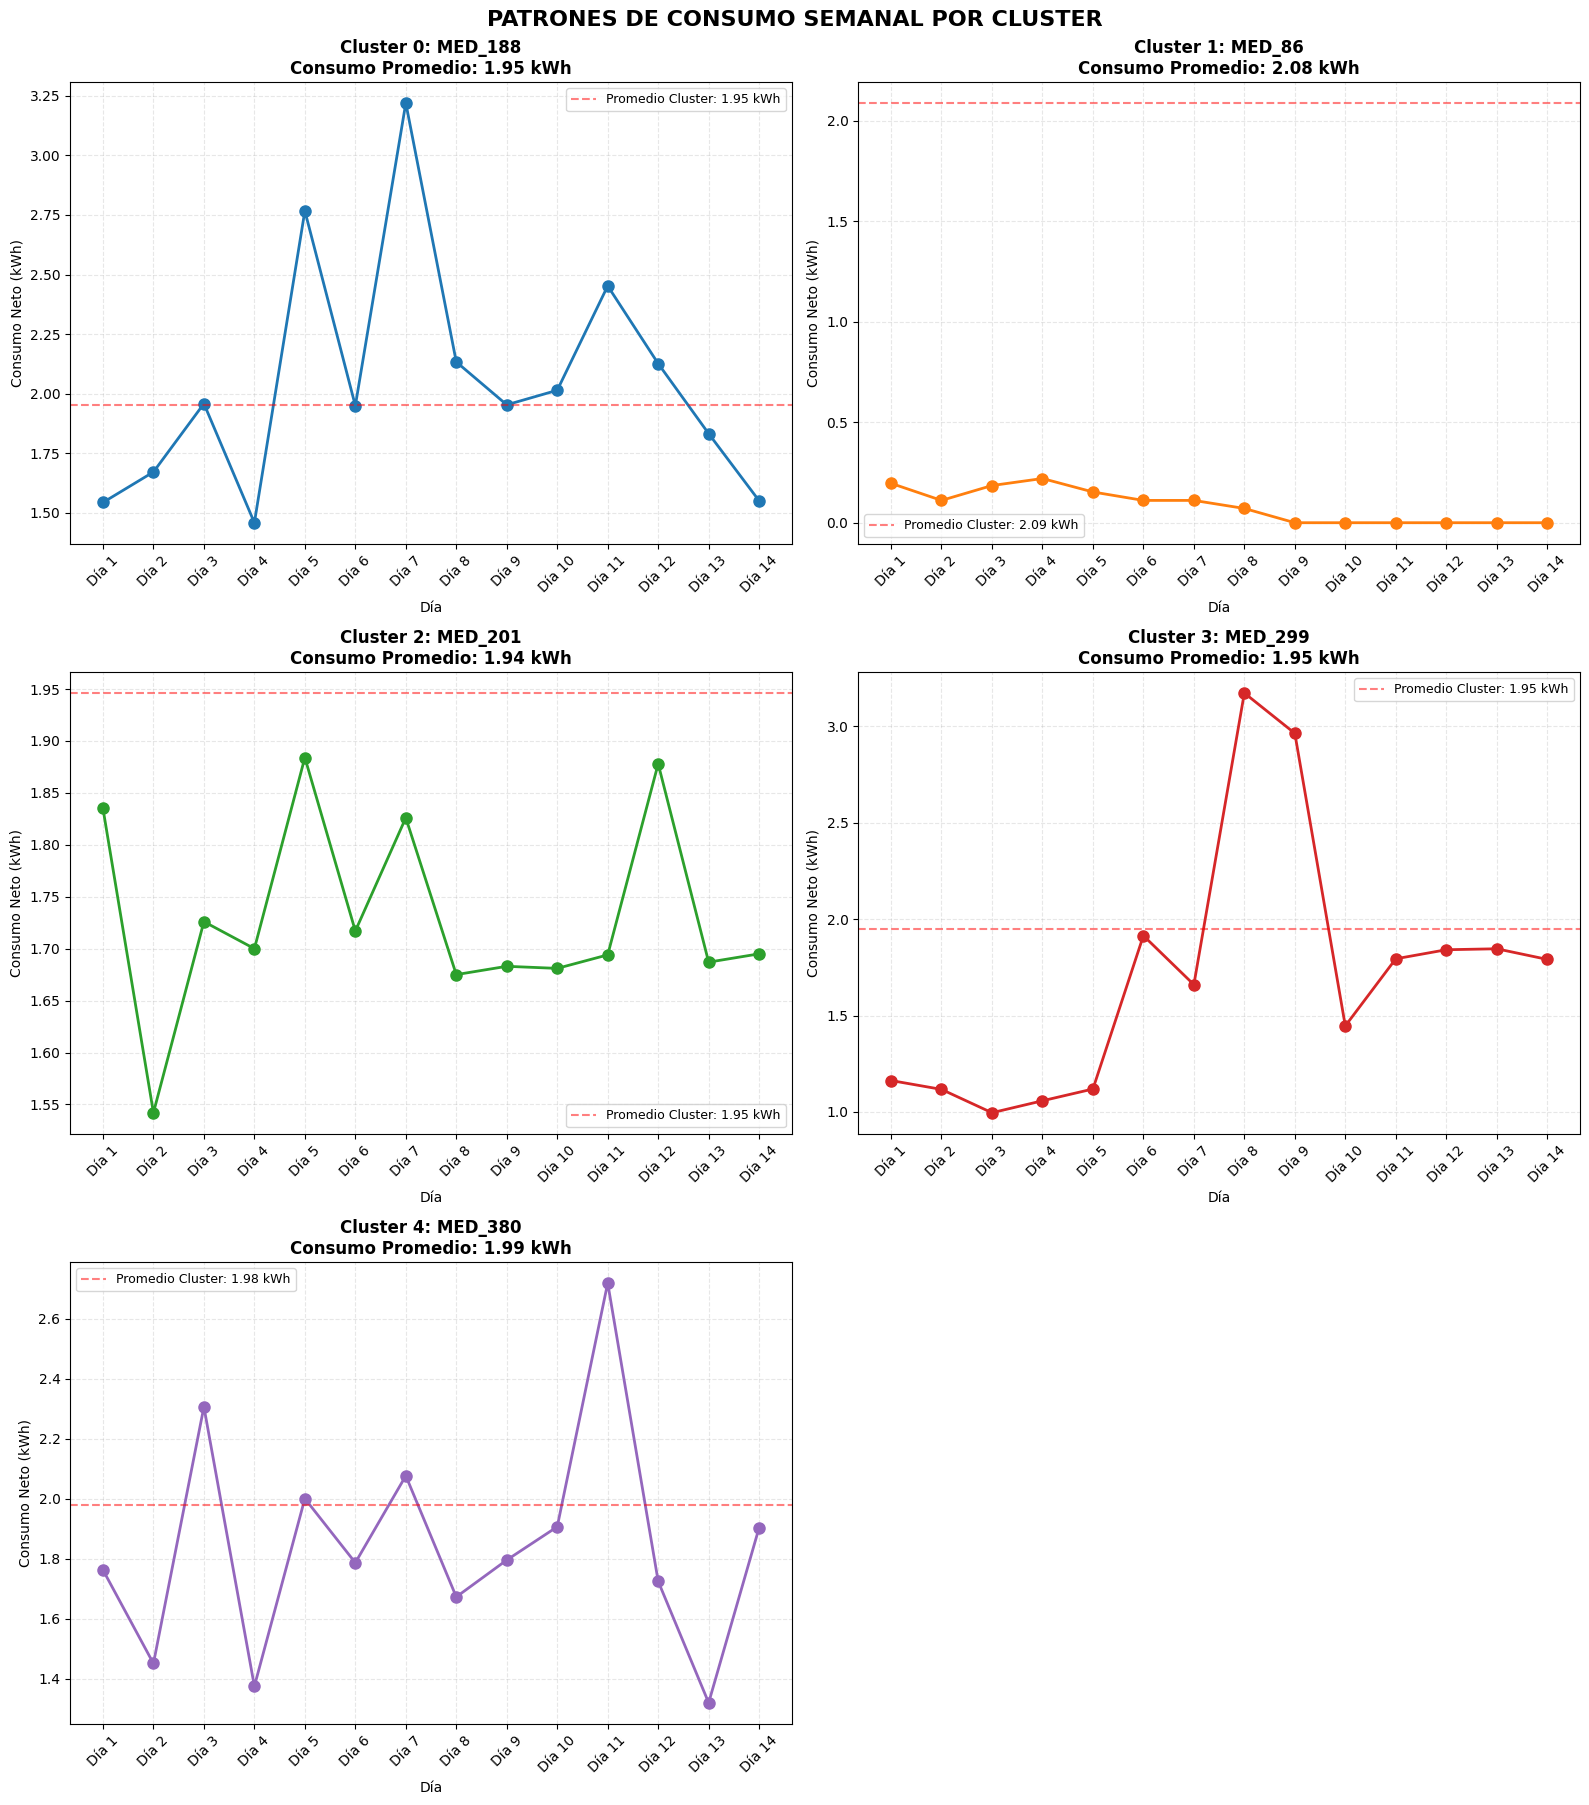

In [64]:
# Visualizar patrones de consumo semanal
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for idx, rep in enumerate(representative_meters):
    cluster_id = rep['cluster']
    meter_id = rep['meter_id']
    
    # Get meter data (take first 7 days available)
    meter_data = data_clustered[
        (data_clustered['ID'] == meter_id) & 
        (data_clustered['CLUSTER'] == cluster_id)
    ].sort_values('FECHA').head(14)
    
    ax = axes[idx]
    
    # Plot consumption
    ax.plot(range(len(meter_data)), meter_data['CONSUMO_NETO'].values, 
            marker='o', linewidth=2, markersize=8, color=f'C{cluster_id}')
    
    # Formatting
    ax.set_title(f'Cluster {cluster_id}: {meter_id}\n' + 
                 f'Consumo Promedio: {rep["avg_consumo"]:.2f} kWh',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Día', fontsize=10)
    ax.set_ylabel('Consumo Neto (kWh)', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks(range(len(meter_data)))
    ax.set_xticklabels([f'Día {i+1}' for i in range(len(meter_data))], rotation=45)
    
    # Add horizontal line for cluster average
    cluster_avg = cluster_stats_df[cluster_stats_df['cluster'] == cluster_id]['avg_consumo'].values[0]
    ax.axhline(y=cluster_avg, color='red', linestyle='--', alpha=0.5, 
               label=f'Promedio Cluster: {cluster_avg:.2f} kWh')
    ax.legend(fontsize=9)

# Remove extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.suptitle('PATRONES DE CONSUMO SEMANAL POR CLUSTER', 
             fontsize=16, fontweight='bold', y=1.00)
plt.subplots_adjust(top=0.96)
plt.show()

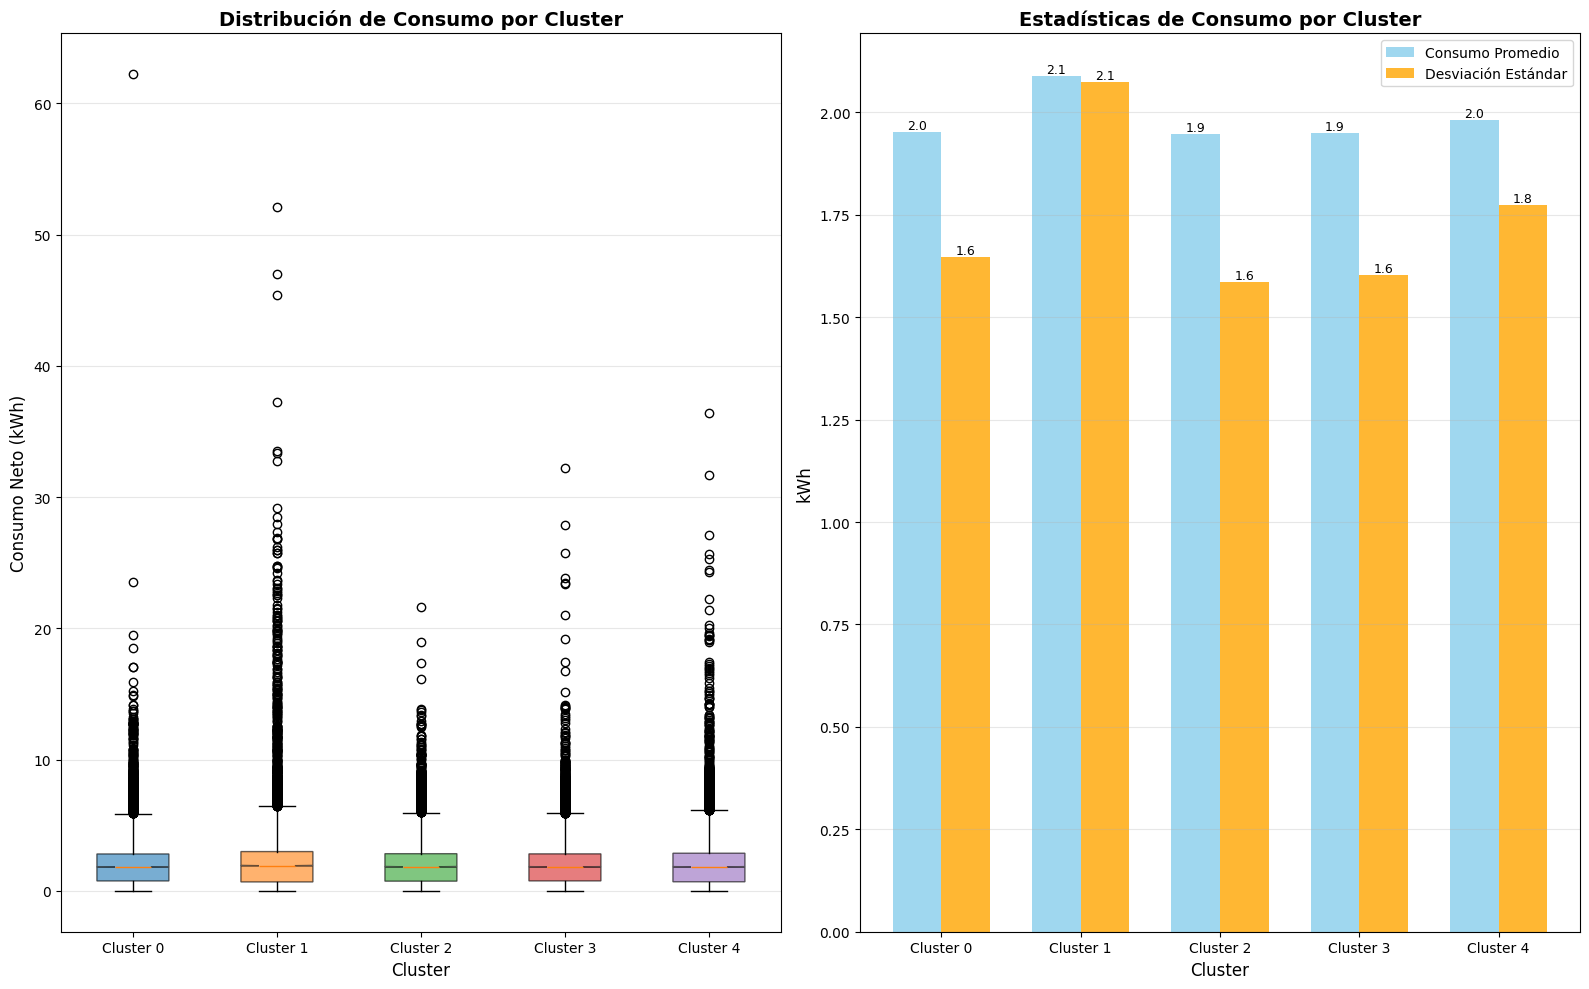

In [62]:
# Comparación de grupos - BOX PLOTS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Box plot of consumption by cluster
data_for_box = [data_clustered[data_clustered['CLUSTER'] == i]['CONSUMO_NETO'].values 
                for i in range(5)]

bp1 = ax1.boxplot(data_for_box, labels=[f'Cluster {i}' for i in range(5)],
                   patch_artist=True, notch=True)

# Color boxes
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax1.set_title('Distribución de Consumo por Cluster', fontsize=14, fontweight='bold')
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_ylabel('Consumo Neto (kWh)', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')

# Bar plot of cluster statistics
x_pos = np.arange(5)
width = 0.35

bars1 = ax2.bar(x_pos - width/2, cluster_stats_df['avg_consumo'], width,
                label='Consumo Promedio', color='skyblue', alpha=0.8)
bars2 = ax2.bar(x_pos + width/2, cluster_stats_df['std_consumo'], width,
                label='Desviación Estándar', color='orange', alpha=0.8)

ax2.set_title('Estadísticas de Consumo por Cluster', fontsize=14, fontweight='bold')
ax2.set_xlabel('Cluster', fontsize=12)
ax2.set_ylabel('kWh', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Cluster {i}' for i in range(5)])
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
#Interpretación de grupos
print(f"\n" + "="*70)
print(f"INTERPRETACIÓN DE LOS CLUSTERS:")
print(f"="*70)

for cluster_id in range(5):
    stats = cluster_stats_df[cluster_stats_df['cluster'] == cluster_id].iloc[0]
    
    print(f"\nCLUSTER {cluster_id}:")
    print(f"   Consumo Promedio: {stats['avg_consumo']:.2f} kWh")
    print(f"   Desviación:       {stats['std_consumo']:.2f} kWh")
    print(f"   Medidores:        {stats['n_meters']}")
    
    # Classify consumption level
    if stats['avg_consumo'] < cluster_stats_df['avg_consumo'].quantile(0.33):
        consumption_level = "BAJO"
        interpretation = "Consumidores de bajo consumo"
    elif stats['avg_consumo'] < cluster_stats_df['avg_consumo'].quantile(0.67):
        consumption_level = "MEDIO"
        interpretation = "Consumidores típicos"
    else:
        consumption_level = "ALTO"
        interpretation = "Consumidores de alto consumo"
    
    # Classify variability
    if stats['std_consumo'] < cluster_stats_df['std_consumo'].quantile(0.5):
        variability = "Consumo ESTABLE"
    else:
        variability = "Consumo VARIABLE"
    
    print(f"   Clasificación:    {consumption_level}")
    print(f"   Variabilidad:     {variability}")
    print(f"   Interpretación:   {interpretation}")



INTERPRETACIÓN DE LOS CLUSTERS:

CLUSTER 0:
   Consumo Promedio: 1.95 kWh
   Desviación:       1.65 kWh
   Medidores:        393.0
   Clasificación:    MEDIO
   Variabilidad:     Consumo VARIABLE
   Interpretación:   Consumidores residenciales típicos

CLUSTER 1:
   Consumo Promedio: 2.09 kWh
   Desviación:       2.07 kWh
   Medidores:        393.0
   Clasificación:    ALTO
   Variabilidad:     Consumo VARIABLE
   Interpretación:   Consumidores de alto consumo o comerciales

CLUSTER 2:
   Consumo Promedio: 1.95 kWh
   Desviación:       1.59 kWh
   Medidores:        393.0
   Clasificación:    BAJO
   Variabilidad:     Consumo ESTABLE
   Interpretación:   Consumidores residenciales de bajo consumo

CLUSTER 3:
   Consumo Promedio: 1.95 kWh
   Desviación:       1.60 kWh
   Medidores:        393.0
   Clasificación:    BAJO
   Variabilidad:     Consumo ESTABLE
   Interpretación:   Consumidores residenciales de bajo consumo

CLUSTER 4:
   Consumo Promedio: 1.98 kWh
   Desviación:       1.77 

In [70]:
#Resultados
# Guardar datos clusterizados
data_clustered.to_csv('results/data_with_clusters.csv', index=False)
print(f"Datos con clusters: results/data_with_clusters.csv")

# Save cluster statistics
cluster_stats_df.to_csv('results/cluster_statistics.csv', index=False)
print(f"Estadísticas: results/cluster_statistics.csv")


Datos con clusters: results/data_with_clusters.csv
Estadísticas: results/cluster_statistics.csv
